# Entrenamiento y prueba de los modelos predictivos

### Resumen del notebok
* Normalizacion de los datos
* Prueba de diferentes modelos de prediccion
* Ajuste de hiperparametros
* Seleccion del mejor modelo

## Objetivos
* Crear un modelo de predicción del ganador de una pelea de MMA que supere la probabilidad aleatoria inicial del 50%
* Evaluar si es posible elaborar un modelo de predicción del resultado de una pelea de MMA teniendo en cuenta tan solo las cualidades técnicas y físicas de ambos peleadores


# Instalamos librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importamos las librerias necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Dropout
from imblearn.over_sampling import SMOTE
import joblib 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import convert_to_tensor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import optimizers
from keras import regularizers
from sklearn import metrics


2023-02-09 09:16:59.784324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 09:16:59.784349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000000

In [4]:
# Creacion de fucniones para facilitar el entrenamiento de los modelos iniciales

def Model(model):
    #Entrenamiento del modelo
    model.fit(X_train, y_train)
    
    # Prediccion X_test
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    #matriz de confusion, curva ROC
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = round(metrics.roc_auc_score(y_test, y_pred_proba), 3)
    plt.rcParams['font.size'] = 12
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_data = [round(value, 0) for value in cm.flatten()]
    labels = [data for data in cm_data]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize = (5,4))
    sns.heatmap(cm, annot = labels, fmt = 'd',
                linewidths=0.5, cmap = 'OrRd', 
                ax=ax)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

        
    #Calculo metricas
    f1 = round(metrics.f1_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    print(f'F1 Score = {round(f1, 3)}')
    print(f'Precisión = {round(precision, 3)}')
    print(f'Recall = {round(recall, 3)}')
    
    return [model, f1, precision, recall, auc, fpr, tpr]



### Carga de los datos

In [5]:
df = pd.read_csv('df_final_1.csv')

In [6]:
df.head()

,winner,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
0,0,5.0,0.0,8.0,-22.0,-7.0,0.0,3.58,5.0,-1.08,-4.0,-2.11,-33.0,13.0,-0.9,-12.0,-16.0,4.0,0.0,-1.0,0.0,1.0,0.0
1,1,-3.0,0.0,-3.0,-14.0,-4.0,1.0,0.70,-7.0,-1.13,-4.0,2.59,24.0,17.0,-0.9,-14.0,-11.0,1.0,0.0,-1.0,0.0,1.0,0.0
2,1,5.0,0.0,0.0,3.0,7.0,0.0,-0.74,-2.0,-0.06,-9.0,-1.67,-6.0,-12.0,-0.2,-9.0,-6.0,-2.0,0.0,0.0,0.0,0.0,0.0
3,0,2.0,0.0,10.0,-5.0,-4.0,1.0,2.04,6.0,0.97,-11.0,-1.73,67.0,8.0,-0.5,-13.0,-19.0,-4.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,5.0,-4.0,1.0,1.0,-0.32,0.0,-1.62,3.0,-1.14,20.0,8.0,-0.7,-4.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0


ValueError: Could not interpret input 'winner'

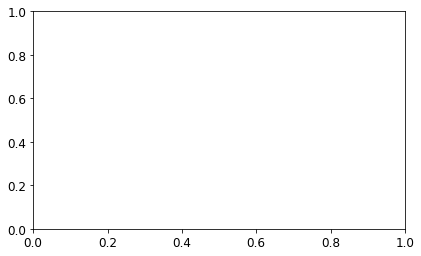

In [65]:
#Cantidad de ganadores "visitantes" y "locales"

#Que el sean el peleador 1 o 0 no influye en el resultado como puede ocurrir en otros deportes como el futbol
#Revisar precision y recall, deben ser similares en nuestro caso de uso

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize = (6.66,4))
sns.countplot(data = df, x= 'winner');

### Normalizacion y division en train y test

In [8]:
# Hacemos un escalado de las variables numericas
scaler = StandardScaler()
scaler.fit(df[df.columns[1:-5]])
df[df.columns[1:-5]] = scaler.transform(df.iloc[:, 1:-5])

#Guardamos los parametros del scaler para usarlo en las predicciones del frontend
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [9]:
df.head()

,winner,Height,Weight,Reach,W,L,D,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,edad,ufc_bouts,racha,St_Open Stance,St_Orthodox,St_Sideways,St_Southpaw,St_Switch
0,0,0.780330,-0.000128,0.989626,-1.995719,-1.362390,-0.032864,2.268849,0.415477,-0.691413,-0.366209,-1.161539,-1.156257,0.437342,-0.861187,-2.226281,-2.607025,1.808143,0.0,-1.0,0.0,1.0,0.0
1,1,-0.457104,-0.000128,-0.319902,-1.275461,-0.787846,1.052941,0.454134,-0.597649,-0.722166,-0.366209,1.453652,0.865689,0.572893,-0.861187,-2.594323,-1.790023,0.464258,0.0,-1.0,0.0,1.0,0.0
2,1,0.780330,-0.000128,0.037242,0.255089,1.318816,-0.032864,-0.453223,-0.175513,-0.064053,-0.802829,-0.916713,-0.198493,-0.409851,-0.192726,-1.674217,-0.973021,-0.879626,0.0,0.0,0.0,0.0,0.0
3,0,0.316292,-0.000128,1.227722,-0.465169,-0.787846,1.052941,1.298481,0.499904,0.569457,-0.977477,-0.950098,2.391017,0.267904,-0.479209,-2.410302,-3.097226,-1.775549,0.0,0.0,0.0,0.0,0.0
4,1,0.006933,-0.000128,0.632482,-0.375137,0.169728,1.052941,-0.188577,-0.006659,-1.023544,0.245059,-0.621808,0.723798,0.267904,-0.670198,-0.754112,-0.646220,0.016297,0.0,0.0,0.0,0.0,0.0


In [10]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:],
                                        df['winner'],
                                        test_size = 0.2,
                                        random_state = 19,
                                        shuffle = True
                                    )

* Modelo inicial

F1 Score = 0.704
Precisión = 0.674
Recall = 0.736


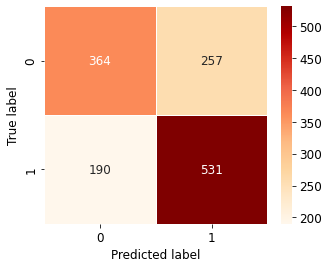

In [11]:
reg_logi_f1 = Model(LogisticRegression(random_state = 19))

* Como se puede observar en la matriz de confusión y en las metricas utilizadas, hay una tendencia del modelo a predecir como ganador al peleador1
* Esto no deberia ocurrir ya que la asignacion de peleador0 y peleador1 es aleatoria por lo que le desbalance de clases puede estar jugando un papel importante
* Usaremos SMOTE para aumentar generar nuevos datos sinteticos que solucionen este problema

In [12]:
sm = SMOTE(random_state=19)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

### Screening de diferentes tipos de modelos para clasificacion binaria

* Regresion logistica

F1 Score = 0.674
Precisión = 0.694
Recall = 0.656


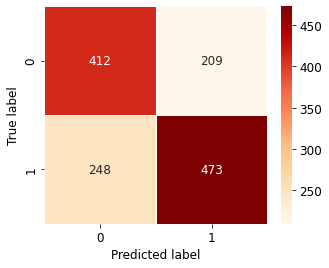

In [13]:
models = []

reg_logi_f1 = Model(LogisticRegression(random_state = 19))
models.append(['Logistic Regression'] + reg_logi_f1)

* Support Vector Machine

F1 Score = 0.674
Precisión = 0.694
Recall = 0.656


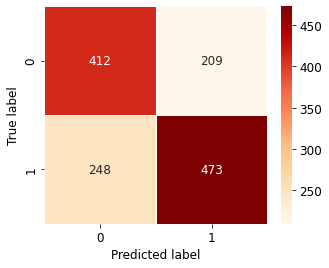

In [14]:
SVC(random_state = 19)
SVC_f1 = Model(LogisticRegression(random_state = 29))
models.append(['Support Vector Machine'] + SVC_f1)

* Random Forest

F1 Score = 0.672
Precisión = 0.672
Recall = 0.673


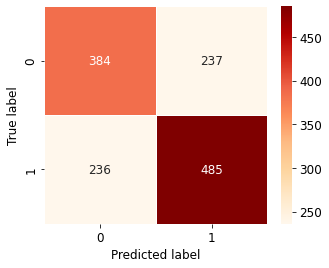

In [15]:
rand_forest_f1 = Model(RandomForestClassifier(random_state = 29))
models.append(['Random forest'] + rand_forest_f1)


* Xboost

F1 Score = 0.665
Precisión = 0.653
Recall = 0.677


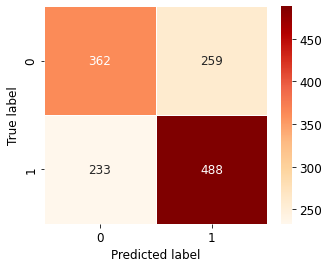

In [16]:
xboost = Model(xgb.XGBClassifier(max_depth=20, objective='binary:logistic', random_state =19))
models.append(['Xboost'] + xboost)

* K-vecinos más cercanos (KNN) 

F1 Score = 0.572
Precisión = 0.617
Recall = 0.533


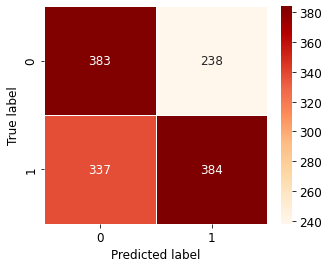

In [17]:
knn = Model(KNeighborsClassifier())
models.append(['KNeighbors'] + knn)

In [18]:
# Tabla datos modelos iniciales
df = pd.DataFrame(models, columns=['Model name','Modelo', 'F1', 'Precision', 'Recall', 'AUC', 'tpr', 'fpr'])
df[['Model name', 'F1', 'Precision', 'Recall', 'AUC']]

,Model name,F1,Precision,Recall,AUC
0,Logistic Regression,0.674,0.694,0.656,0.731
1,Support Vector Machine,0.674,0.694,0.656,0.731
2,Random forest,0.672,0.672,0.673,0.710
3,Xboost,0.665,0.653,0.677,0.690
4,KNeighbors,0.572,0.617,0.533,0.614


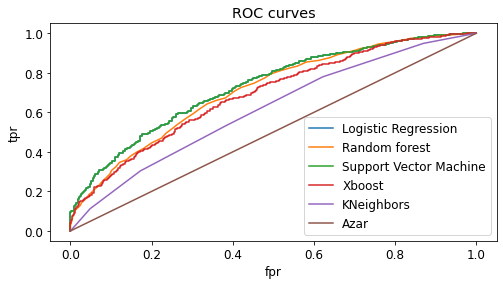

In [19]:
#ROC curves
fig, ax = plt.subplots(figsize = (8, 4))

plt.title('ROC curves')
plt.xlabel('fpr')
plt.ylabel('tpr')

fpr = df[df['Model name'] == 'Logistic Regression']['fpr']
tpr = df[df['Model name'] == 'Logistic Regression']['tpr']
ax.plot(tpr.values[0], 
         fpr.values[0], 
         label = 'Logistic Regression')

fpr = df[df['Model name'] == 'Random forest']['fpr']
tpr = df[df['Model name'] == 'Random forest']['tpr']
ax.plot(tpr.values[0], 
         fpr.values[0], 
         label = 'Random forest')


fpr = df[df['Model name'] == 'Support Vector Machine']['fpr']
tpr = df[df['Model name'] == 'Support Vector Machine']['tpr']
ax.plot(tpr.values[0], 
         fpr.values[0], 
         label = 'Support Vector Machine')


fpr = df[df['Model name'] == 'Xboost']['fpr']
tpr = df[df['Model name'] == 'Xboost']['tpr']
ax.plot(tpr.values[0], 
         fpr.values[0], 
         label = 'Xboost')

fpr = df[df['Model name'] == 'KNeighbors']['fpr']
tpr = df[df['Model name'] == 'KNeighbors']['tpr']
ax.plot(tpr.values[0], 
         fpr.values[0], 
         label = 'KNeighbors')

ax.plot([0,1], 
         [0,1], 
         label = 'Azar')

plt.legend();

### Conclusiones
* Resultados muy similares independientemente del algoritmo empleado. 
* Seleccionamos Random Forest para una optimizacion de los hiperparametros. Se selecciona este modelo ya que presenta una precision y recall mas similares (no deberia influir el orden en el resultado) y ofrece mas opciones en el ajuste de los hiperparametros que la regresion lineal que tiene una precision similar

### Ajuste hiperparametros

In [21]:
#Ajuste hiperparametros Random Forest
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [4, 6, 8, 9],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# Inicializamos grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state = 19), 
                           param_grid = param_grid, cv = 3, verbose=2)

# Ajustamos grid search
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación: ", round(grid_search.best_score_, 3))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   1.9s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   1.8s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   1.6s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   3.0s
[CV] END max_depth=50, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   3.3s


[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   2.7s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   2.6s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   1.6s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   1.6s
[CV] END max_depth=50, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   1.7s
[CV] END max_depth=50, max_features=4, min_samples_leaf=

[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   2.4s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   3.6s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   3.9s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   3.6s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END max_depth=50, max_features=6, min_samples_leaf=3, m

[CV] END max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   2.2s
[CV] END max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   2.4s
[CV] END max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   2.0s
[CV] END max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   3.8s
[CV] END max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   3.5s
[CV] END max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   3.5s
[CV] END max_depth=50, max_features=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=8, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=8, min_samples_leaf=2,

[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.4s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  10.1s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  10.5s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   9.5s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  16.5s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  16.1s
[CV] END max_depth=50, max_features=8, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  15.1s
[CV] END max_depth=50, max_features=8, min_samples_leaf=

[CV] END max_depth=50, max_features=9, min_samples_leaf=2, min_samples_split=12, n_estimators=500; total time=   5.5s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   3.7s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   3.1s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   3.3s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   5.5s
[CV] END max_depth=50, max_features=9, min_samples_leaf=3, min_

[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   5.1s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   5.7s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   5.3s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.0s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   3.1s
[CV] END max_depth=50, max_features=9, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   3.5s
[CV] END max_depth=50, max_features=9, min_samples_leaf=

[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.8s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.9s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   3.0s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   3.3s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   3.9s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=80, max_features=4, min_samples_leaf=4, mi

[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=100; total time=   0.8s
[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=300; total time=   2.7s
[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=300; total time=   2.5s
[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=300; total time=   2.4s
[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=500; total time=   4.6s
[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=500; total time=   4.5s
[CV] END max_depth=80, max_features=6, min_samples_leaf=2, min_samples_split=12, n_estimators=500; total time=   5.0s
[CV] END max_depth=80, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.8s
[CV] END max_depth=80, max_features=6, min_samples_leaf=3

[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   3.1s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   4.0s
[CV] END max_depth=80, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   4.3s
[CV] END max_depth=80, max_features=6, min_samples_leaf=

[CV] END max_depth=80, max_features=8, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   5.4s
[CV] END max_depth=80, max_features=8, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   4.9s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   2.9s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   3.4s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   2.8s
[CV] END max_depth=80, max_features=8, min_samples_leaf=4, min

[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.1s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.0s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   5.9s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   5.9s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=12, n_estimators=100; total time=   1.2s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=12, n_estimators=100; total time=   1.3s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=12, n_estimators=100; total time=   3.8s
[CV] END max_depth=80, max_features=9, min_samples_leaf=2, min_samples_split=12, n_estimators=300; total time=   4.1s
[CV] END max_depth=80, max_features=9, min_samples_leaf=

[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   3.3s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   3.4s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   3.3s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   5.5s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.0s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.0s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END max_depth=80, max_features=9, min_samples_leaf=5, min

[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.7s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   1.9s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   2.0s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   2.2s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   3.8s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   4.5s
[CV] END max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   3.8s
[CV] END max_depth=100, max_features=4, min_samp

[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   3.7s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END max_depth=100, max_features=6, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   3.8s
[CV] END max_depth=100, max_features=6, min_sampl

[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=500; total time=   3.5s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=500; total time=   3.5s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=500; total time=   3.3s
[CV] END max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   2.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   2.2s
[CV] END max_depth=100, max_features=6, min_samples_l

[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   4.5s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   4.5s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   4.2s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=100, max_features=8, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=100, max_features=8, min_samp

[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   3.0s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   3.1s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   2.9s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   5.1s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   5.2s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   4.8s
[CV] END max_depth=100, max_features=9, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=100, max_features=9, min_samples_lea

[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.9s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   2.9s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   2.8s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   2.6s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=500; total time=   4.7s
[CV] END max_depth=100, max_features=9, min_samples_leaf=4, min_samples_split=12, n_estimators=500; total time=   4.8s
[CV] END max_depth=100, max_features=9, min_samp

## Resultados finales en cojunto test

In [34]:
model = grid_search.best_estimator_

F1 Score = 0.678
Precisión = 0.677
Recall = 0.678


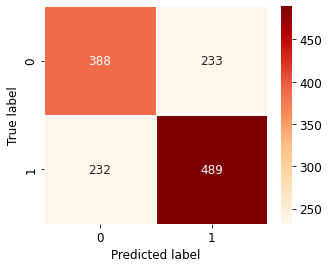

In [35]:
rand_forest = Model(model)

In [39]:
joblib.dump(model, 'modelo_random_forest.joblib')

['modelo_random_forest.joblib']

### Ninguno de los ajustes de los hiperparametros resulta en una mejora del modelo notable
#### Probamos una red neuronal como posible mejora del proyecto

In [40]:
# Obtencion del numero de variables para adaptar el tamaño de entrada de la red neuronal
nvar=X_train.shape[1]

In [41]:
#Funcion para ayudar a evaluar las redes neuronales y optimizar los hiperparametros

def create_model(neurons = 30, layers = 10, activation = 'relu', 
                 optimizer = 'adam', batch_size = 300, epochs = 20,
                regu = None, dropout_rate = 0):
    
    model = Sequential()

    l1 = Dense(units = neurons, input_shape=(nvar, ), kernel_regularizer = regu)
    model.add(l1)

    for i in range(1, layers):
        l2 = Dense(units = neurons, activation = activation, kernel_regularizer = regu)
        model.add(l2)
        model.add(Dropout(dropout_rate))
    
    out = Dense(units = 2, activation='sigmoid')
    model.add(out)
    
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics = ["accuracy"])
    
    hist = model.fit(x = convert_to_tensor(X_train), 
                     y = to_categorical(convert_to_tensor(y_train), num_classes = 2), 
                                        batch_size = batch_size, 
                                        validation_split = 0.3, 
                                        epochs = epochs)

    return model


# Funcion de ayuda para visualizar las metricas
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.show()

Epoch 1/20
14/14 [==============================] - 1s 15ms/step - loss: 0.6897 - accuracy: 0.5689 - val_loss: 0.6905 - val_accuracy: 0.5131
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6692 - accuracy: 0.6181 - val_loss: 0.6686 - val_accuracy: 0.5840
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6374 - accuracy: 0.6446 - val_loss: 0.6305 - val_accuracy: 0.6394
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6203 - accuracy: 0.6598 - val_loss: 0.6054 - val_accuracy: 0.6594
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6094 - accuracy: 0.6672 - val_loss: 0.5977 - val_accuracy: 0.6697
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.6706 - val_loss: 0.6002 - val_accuracy: 0.6646
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5978 - accuracy: 0.6775 - val_loss: 0.6128 - val_accuracy: 0.6583
Epoch 8/20
14/14 [

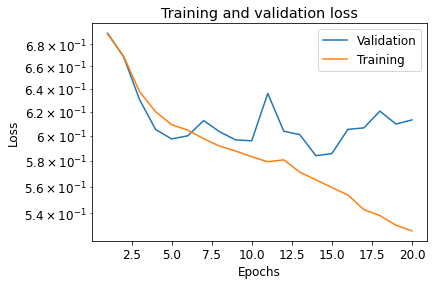

In [59]:
# Red neuronal inicial
model = create_model()
plot_metric(model.history, 'loss')

* Obtenemos un resultado similar al resto de modelos
* Ajustaremos hiperparametros de la red neuronal intentando obtener un mejor resultado

---------------------------------
SGD
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 20ms/step - loss: 0.6923 - accuracy: 0.5662 - val_loss: 0.6921 - val_accuracy: 0.5817
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5890 - val_loss: 0.6926 - val_accuracy: 0.5366
Epoch 3/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5944 - val_loss: 0.6930 - val_accuracy: 0.4874
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5895 - val_loss: 0.6935 - val_accuracy: 0.4663
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5855 - val_loss: 0.6939 - val_accuracy: 0.4497
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5755 - val_loss: 0.6944 - val_accuracy: 0.4229
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6908 - accura

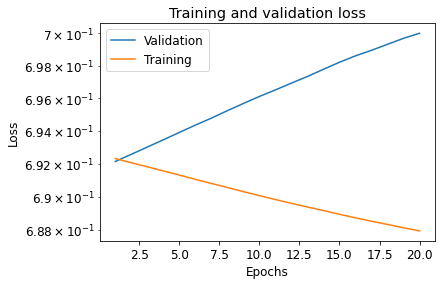

---------------------------------
RMSprop
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 14ms/step - loss: 0.6732 - accuracy: 0.5924 - val_loss: 0.6554 - val_accuracy: 0.6149
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6537 - val_loss: 0.6566 - val_accuracy: 0.6183
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6105 - accuracy: 0.6647 - val_loss: 0.6034 - val_accuracy: 0.6623
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6037 - accuracy: 0.6699 - val_loss: 0.6286 - val_accuracy: 0.6457
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.5998 - accuracy: 0.6794 - val_loss: 0.6087 - val_accuracy: 0.6629
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5934 - accuracy: 0.6841 - val_loss: 0.5988 - val_accuracy: 0.6726
Epoch 7/20
14/14 [==============================] - 0s 6ms/step - loss: 0.5917 - ac

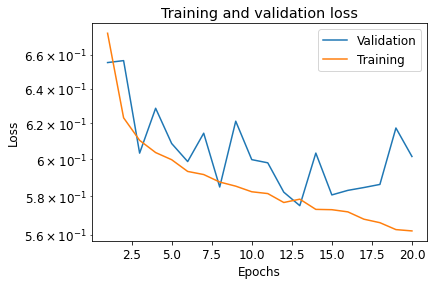

---------------------------------
Adam
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 18ms/step - loss: 0.6866 - accuracy: 0.5458 - val_loss: 0.7015 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6617 - accuracy: 0.5581 - val_loss: 0.6831 - val_accuracy: 0.5743
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6395 - accuracy: 0.6493 - val_loss: 0.6478 - val_accuracy: 0.6657
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.6603 - val_loss: 0.5964 - val_accuracy: 0.6840
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.6674 - val_loss: 0.5911 - val_accuracy: 0.6680
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5973 - accuracy: 0.6782 - val_loss: 0.5764 - val_accuracy: 0.6874
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5933 - accur

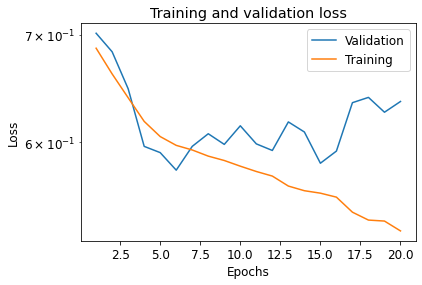

---------------------------------
Nadam
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 21ms/step - loss: 0.6891 - accuracy: 0.5686 - val_loss: 0.6950 - val_accuracy: 0.4663
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6599 - accuracy: 0.6277 - val_loss: 0.6464 - val_accuracy: 0.6200
Epoch 3/20
14/14 [==============================] - 0s 14ms/step - loss: 0.6211 - accuracy: 0.6561 - val_loss: 0.6126 - val_accuracy: 0.6566
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6067 - accuracy: 0.6708 - val_loss: 0.5936 - val_accuracy: 0.6697
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6028 - accuracy: 0.6718 - val_loss: 0.6184 - val_accuracy: 0.6429
Epoch 6/20
14/14 [==============================] - 0s 12ms/step - loss: 0.5963 - accuracy: 0.6794 - val_loss: 0.5983 - val_accuracy: 0.6663
Epoch 7/20
14/14 [==============================] - 0s 16ms/step - loss: 0.5908 - 

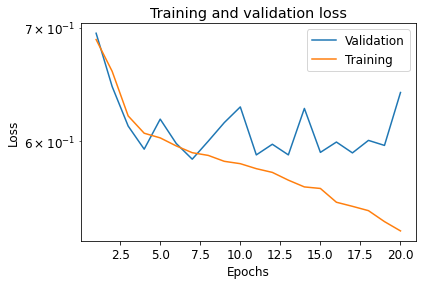

In [61]:
#Eleccion del optimizador

op_optimizer = ['SGD', 'RMSprop', 'Adam', 'Nadam']
models_optimizer = []

for optimizer in op_optimizer:
    print('---------------------------------')
    print(f'{optimizer}')
    print('---------------------------------')
    
    model = create_model(optimizer = optimizer)
    plot_metric(model.history, 'loss')
    models_optimizer.append((optimizer, max(model.history.history['val_accuracy'])))

In [62]:
models_optimizer

[('SGD', 0.5817142724990845),
 ('RMSprop', 0.6891428828239441),
 ('Adam', 0.6897143125534058),
 ('Nadam', 0.6862857341766357)]

## Selecciono Adam por su grafica de loss y su accuracy

---------------------------------
relu
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 23ms/step - loss: 0.6914 - accuracy: 0.5534 - val_loss: 0.6932 - val_accuracy: 0.4646
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6752 - accuracy: 0.6245 - val_loss: 0.6680 - val_accuracy: 0.6274
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6332 - accuracy: 0.6603 - val_loss: 0.6255 - val_accuracy: 0.6554
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6118 - accuracy: 0.6625 - val_loss: 0.6213 - val_accuracy: 0.6400
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6017 - accuracy: 0.6738 - val_loss: 0.6157 - val_accuracy: 0.6446
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.5957 - accuracy: 0.6799 - val_loss: 0.6187 - val_accuracy: 0.6486
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5909 - accur

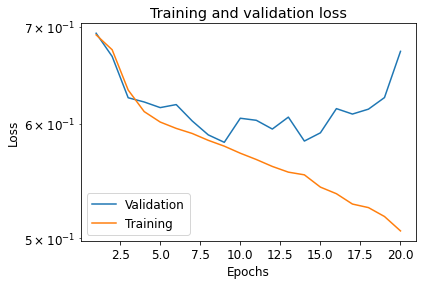

---------------------------------
elu
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 35ms/step - loss: 0.6696 - accuracy: 0.5843 - val_loss: 0.6478 - val_accuracy: 0.6269
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6259 - accuracy: 0.6495 - val_loss: 0.6310 - val_accuracy: 0.6411
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6096 - accuracy: 0.6652 - val_loss: 0.6081 - val_accuracy: 0.6629
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6032 - accuracy: 0.6689 - val_loss: 0.6087 - val_accuracy: 0.6674
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5992 - accuracy: 0.6750 - val_loss: 0.5983 - val_accuracy: 0.6806
Epoch 6/20
14/14 [==============================] - 0s 11ms/step - loss: 0.5969 - accuracy: 0.6708 - val_loss: 0.6103 - val_accuracy: 0.6686
Epoch 7/20
14/14 [==============================] - 0s 10ms/step - loss: 0.5966 - ac

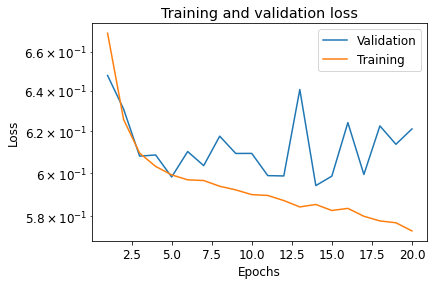

---------------------------------
leaky_relu
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 14ms/step - loss: 0.6806 - accuracy: 0.5458 - val_loss: 0.7114 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.5723 - val_loss: 0.6774 - val_accuracy: 0.6080
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6377 - accuracy: 0.6549 - val_loss: 0.6467 - val_accuracy: 0.6589
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6163 - accuracy: 0.6598 - val_loss: 0.6082 - val_accuracy: 0.6709
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6072 - accuracy: 0.6691 - val_loss: 0.5916 - val_accuracy: 0.6806
Epoch 6/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6026 - accuracy: 0.6723 - val_loss: 0.6121 - val_accuracy: 0.6480
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5980

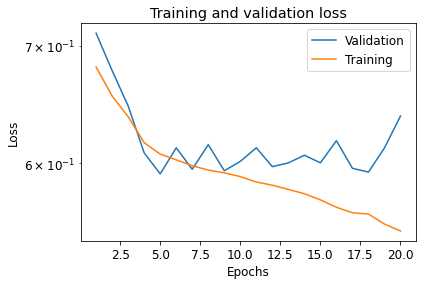

In [48]:
#Eleccion del activador

op_activator = ['relu', 'elu', 'leaky_relu']
models_activator = []

for activator in op_activator:
    print('---------------------------------')
    print(f'{activator}')
    print('---------------------------------')
    
    model = create_model(optimizer = 'Adam', activation = activator)
    plot_metric(model.history, 'loss')
    models_activator.append((activator, max(model.history.history['val_accuracy'])))

In [49]:
models_activator

[('relu', 0.6851428747177124),
 ('elu', 0.680571436882019),
 ('leaky_relu', 0.680571436882019)]

## Selecciono leaky_relu como activador

---------------------------------
10 neurons and 5 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 16ms/step - loss: 0.6989 - accuracy: 0.5098 - val_loss: 0.7091 - val_accuracy: 0.4480
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.5603 - val_loss: 0.6951 - val_accuracy: 0.4971
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6645 - accuracy: 0.5831 - val_loss: 0.6815 - val_accuracy: 0.5354
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6500 - accuracy: 0.6103 - val_loss: 0.6670 - val_accuracy: 0.5743
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6378 - accuracy: 0.6240 - val_loss: 0.6516 - val_accuracy: 0.6000
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6365 - val_loss: 0.6370 - val_accuracy: 0.6291
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - l

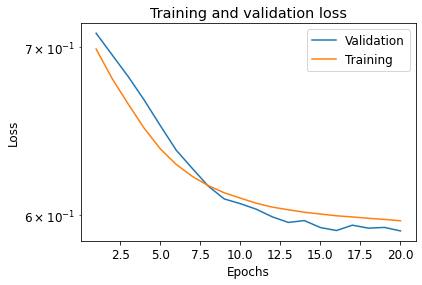

---------------------------------
10 neurons and 10 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 16ms/step - loss: 0.6909 - accuracy: 0.5488 - val_loss: 0.6956 - val_accuracy: 0.4263
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5684 - val_loss: 0.6955 - val_accuracy: 0.4423
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.5934 - val_loss: 0.6867 - val_accuracy: 0.5389
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6427 - accuracy: 0.6272 - val_loss: 0.6651 - val_accuracy: 0.6274
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6284 - accuracy: 0.6461 - val_loss: 0.6380 - val_accuracy: 0.6474
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6196 - accuracy: 0.6556 - val_loss: 0.6235 - val_accuracy: 0.6509
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - 

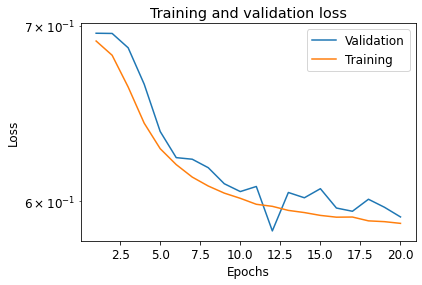

---------------------------------
10 neurons and 15 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 16ms/step - loss: 0.6909 - accuracy: 0.5652 - val_loss: 0.6927 - val_accuracy: 0.5006
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.6037 - val_loss: 0.6783 - val_accuracy: 0.5663
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6601 - accuracy: 0.6297 - val_loss: 0.6574 - val_accuracy: 0.5954
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6415 - accuracy: 0.6466 - val_loss: 0.6520 - val_accuracy: 0.6103
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6512 - val_loss: 0.6540 - val_accuracy: 0.6154
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6242 - accuracy: 0.6547 - val_loss: 0.6333 - val_accuracy: 0.6400
Epoch 7/20
14/14 [==============================] - 0s 6ms/step - 

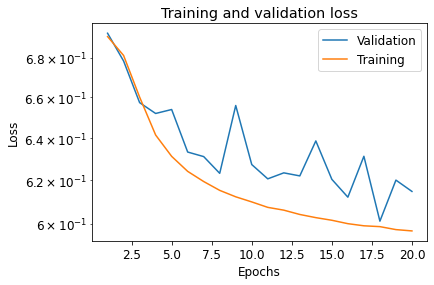

---------------------------------
10 neurons and 20 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 19ms/step - loss: 0.6922 - accuracy: 0.5471 - val_loss: 0.6986 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5471 - val_loss: 0.6959 - val_accuracy: 0.3931
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6764 - accuracy: 0.5814 - val_loss: 0.6747 - val_accuracy: 0.6160
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6436 - accuracy: 0.6549 - val_loss: 0.6344 - val_accuracy: 0.6509
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6304 - accuracy: 0.6632 - val_loss: 0.6437 - val_accuracy: 0.6549
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6231 - accuracy: 0.6676 - val_loss: 0.6281 - val_accuracy: 0.6634
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - 

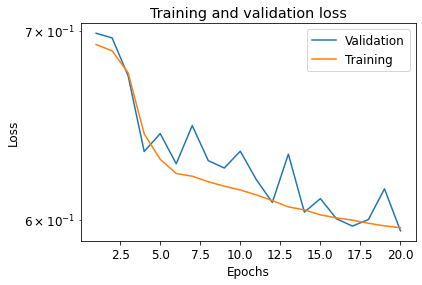

---------------------------------
10 neurons and 25 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 3s 22ms/step - loss: 0.6922 - accuracy: 0.5471 - val_loss: 0.6967 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6893 - accuracy: 0.5471 - val_loss: 0.6982 - val_accuracy: 0.3909
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6734 - accuracy: 0.6120 - val_loss: 0.6562 - val_accuracy: 0.6394
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6423 - accuracy: 0.6544 - val_loss: 0.6367 - val_accuracy: 0.6394
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6264 - accuracy: 0.6625 - val_loss: 0.6423 - val_accuracy: 0.6434
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6196 - accuracy: 0.6642 - val_loss: 0.6152 - val_accuracy: 0.6714
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - 

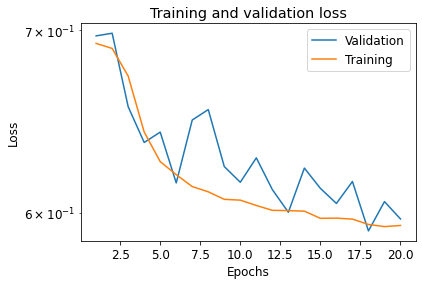

---------------------------------
20 neurons and 5 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 13ms/step - loss: 0.7033 - accuracy: 0.4721 - val_loss: 0.6919 - val_accuracy: 0.5549
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5988 - val_loss: 0.6811 - val_accuracy: 0.5983
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6647 - accuracy: 0.6402 - val_loss: 0.6497 - val_accuracy: 0.6337
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6335 - accuracy: 0.6532 - val_loss: 0.6163 - val_accuracy: 0.6514
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6138 - accuracy: 0.6630 - val_loss: 0.6093 - val_accuracy: 0.6509
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6054 - accuracy: 0.6699 - val_loss: 0.6050 - val_accuracy: 0.6571
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - l

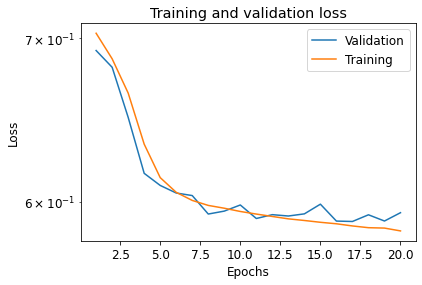

---------------------------------
20 neurons and 10 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 14ms/step - loss: 0.6872 - accuracy: 0.5762 - val_loss: 0.6950 - val_accuracy: 0.4834
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6586 - accuracy: 0.6194 - val_loss: 0.6676 - val_accuracy: 0.6177
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6284 - accuracy: 0.6522 - val_loss: 0.6231 - val_accuracy: 0.6566
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6157 - accuracy: 0.6605 - val_loss: 0.6185 - val_accuracy: 0.6589
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6085 - accuracy: 0.6645 - val_loss: 0.5973 - val_accuracy: 0.6749
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6054 - accuracy: 0.6703 - val_loss: 0.5969 - val_accuracy: 0.6703
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - 

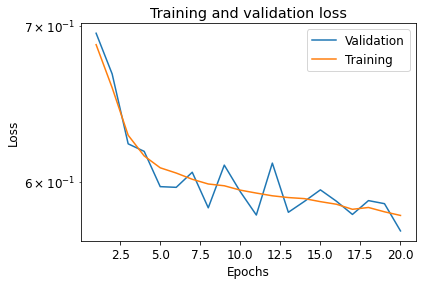

---------------------------------
20 neurons and 15 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 17ms/step - loss: 0.6898 - accuracy: 0.5468 - val_loss: 0.7017 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6640 - accuracy: 0.5502 - val_loss: 0.6826 - val_accuracy: 0.5863
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6373 - accuracy: 0.6566 - val_loss: 0.6591 - val_accuracy: 0.6474
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6182 - accuracy: 0.6654 - val_loss: 0.6092 - val_accuracy: 0.6629
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6055 - accuracy: 0.6743 - val_loss: 0.5928 - val_accuracy: 0.6760
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6009 - accuracy: 0.6843 - val_loss: 0.6029 - val_accuracy: 0.6606
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - 

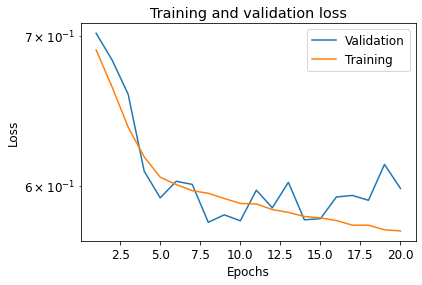

---------------------------------
20 neurons and 20 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 20ms/step - loss: 0.6900 - accuracy: 0.5446 - val_loss: 0.7010 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6638 - accuracy: 0.5855 - val_loss: 0.6607 - val_accuracy: 0.6720
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6359 - accuracy: 0.6429 - val_loss: 0.6329 - val_accuracy: 0.6760
Epoch 4/20
14/14 [==============================] - 0s 11ms/step - loss: 0.6220 - accuracy: 0.6549 - val_loss: 0.6110 - val_accuracy: 0.6760
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6151 - accuracy: 0.6637 - val_loss: 0.5946 - val_accuracy: 0.6834
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6095 - accuracy: 0.6672 - val_loss: 0.5955 - val_accuracy: 0.6823
Epoch 7/20
14/14 [==============================] - 0s 8ms/step

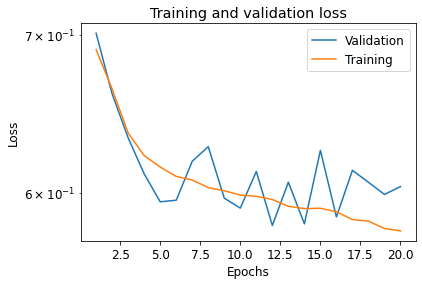

---------------------------------
20 neurons and 25 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 3s 25ms/step - loss: 0.6924 - accuracy: 0.5422 - val_loss: 0.6983 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6847 - accuracy: 0.5471 - val_loss: 0.7165 - val_accuracy: 0.3903
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6460 - accuracy: 0.6032 - val_loss: 0.6165 - val_accuracy: 0.6954
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6197 - accuracy: 0.6549 - val_loss: 0.6042 - val_accuracy: 0.6817
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6088 - accuracy: 0.6711 - val_loss: 0.6116 - val_accuracy: 0.6800
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6014 - accuracy: 0.6762 - val_loss: 0.5933 - val_accuracy: 0.6880
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - 

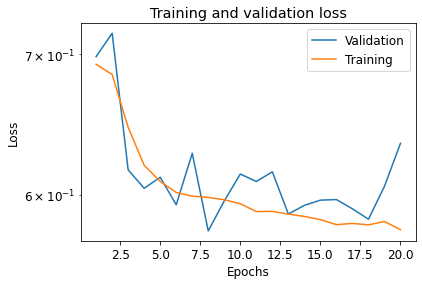

---------------------------------
30 neurons and 5 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 12ms/step - loss: 0.6901 - accuracy: 0.5458 - val_loss: 0.6827 - val_accuracy: 0.5543
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6578 - accuracy: 0.6260 - val_loss: 0.6558 - val_accuracy: 0.6080
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6397 - val_loss: 0.6267 - val_accuracy: 0.6463
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6134 - accuracy: 0.6542 - val_loss: 0.6077 - val_accuracy: 0.6617
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6055 - accuracy: 0.6627 - val_loss: 0.6064 - val_accuracy: 0.6634
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6001 - accuracy: 0.6716 - val_loss: 0.6037 - val_accuracy: 0.6691
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - l

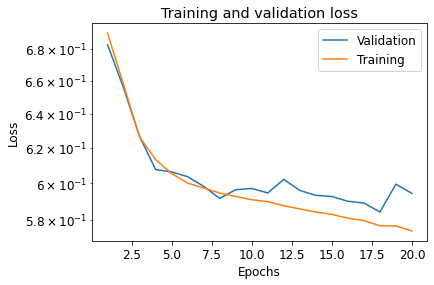

---------------------------------
30 neurons and 10 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 15ms/step - loss: 0.6882 - accuracy: 0.5510 - val_loss: 0.6913 - val_accuracy: 0.4806
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6484 - accuracy: 0.6304 - val_loss: 0.6258 - val_accuracy: 0.6646
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6198 - accuracy: 0.6576 - val_loss: 0.6254 - val_accuracy: 0.6463
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6081 - accuracy: 0.6694 - val_loss: 0.6001 - val_accuracy: 0.6640
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6011 - accuracy: 0.6755 - val_loss: 0.6292 - val_accuracy: 0.6326
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5975 - accuracy: 0.6799 - val_loss: 0.5795 - val_accuracy: 0.6886
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - 

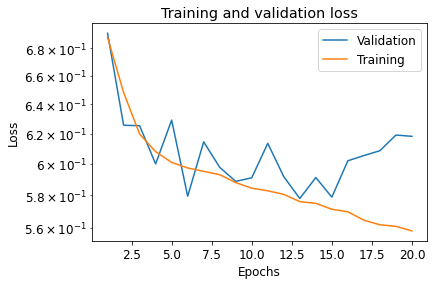

---------------------------------
30 neurons and 15 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 19ms/step - loss: 0.6872 - accuracy: 0.5473 - val_loss: 0.6930 - val_accuracy: 0.5006
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6451 - accuracy: 0.6368 - val_loss: 0.6355 - val_accuracy: 0.6549
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6203 - accuracy: 0.6561 - val_loss: 0.6101 - val_accuracy: 0.6629
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6070 - accuracy: 0.6730 - val_loss: 0.5989 - val_accuracy: 0.6697
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6023 - accuracy: 0.6760 - val_loss: 0.6000 - val_accuracy: 0.6726
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5951 - accuracy: 0.6846 - val_loss: 0.6060 - val_accuracy: 0.6600
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - 

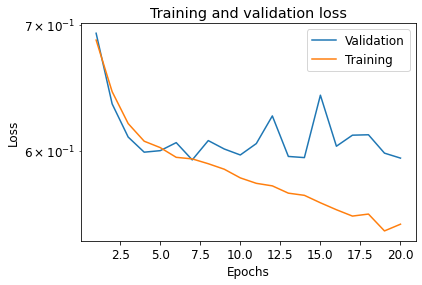

---------------------------------
30 neurons and 20 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 3s 22ms/step - loss: 0.6888 - accuracy: 0.5404 - val_loss: 0.7070 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6516 - accuracy: 0.5953 - val_loss: 0.6759 - val_accuracy: 0.6440
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6228 - accuracy: 0.6574 - val_loss: 0.5971 - val_accuracy: 0.6829
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6118 - accuracy: 0.6662 - val_loss: 0.5960 - val_accuracy: 0.6766
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6014 - accuracy: 0.6767 - val_loss: 0.5838 - val_accuracy: 0.6937
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5984 - accuracy: 0.6787 - val_loss: 0.5877 - val_accuracy: 0.6874
Epoch 7/20
14/14 [==============================] - 0s 10ms/step

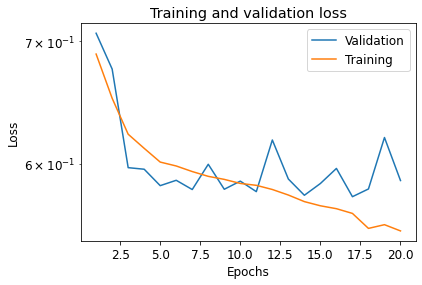

---------------------------------
30 neurons and 25 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 3s 24ms/step - loss: 0.6908 - accuracy: 0.5422 - val_loss: 0.7138 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6580 - accuracy: 0.5598 - val_loss: 0.7069 - val_accuracy: 0.6457
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6351 - accuracy: 0.6534 - val_loss: 0.6268 - val_accuracy: 0.6423
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6129 - accuracy: 0.6672 - val_loss: 0.6174 - val_accuracy: 0.6360
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6018 - accuracy: 0.6757 - val_loss: 0.6342 - val_accuracy: 0.6246
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5995 - accuracy: 0.6757 - val_loss: 0.6013 - val_accuracy: 0.6514
Epoch 7/20
14/14 [==============================] - 0s 9ms/step -

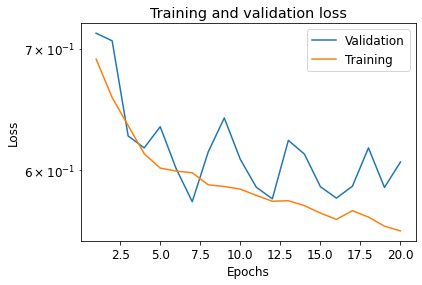

---------------------------------
40 neurons and 5 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 13ms/step - loss: 0.6793 - accuracy: 0.5794 - val_loss: 0.6584 - val_accuracy: 0.6051
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6288 - accuracy: 0.6502 - val_loss: 0.6148 - val_accuracy: 0.6503
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6074 - accuracy: 0.6647 - val_loss: 0.6028 - val_accuracy: 0.6720
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6005 - accuracy: 0.6706 - val_loss: 0.5939 - val_accuracy: 0.6817
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.5969 - accuracy: 0.6789 - val_loss: 0.5952 - val_accuracy: 0.6806
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5929 - accuracy: 0.6735 - val_loss: 0.5912 - val_accuracy: 0.6840
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - l

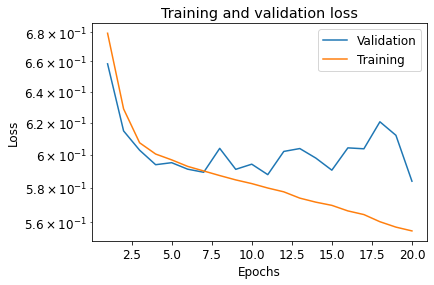

---------------------------------
40 neurons and 10 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 15ms/step - loss: 0.6795 - accuracy: 0.5475 - val_loss: 0.6977 - val_accuracy: 0.4080
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6378 - accuracy: 0.6390 - val_loss: 0.6091 - val_accuracy: 0.6983
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6103 - accuracy: 0.6625 - val_loss: 0.6026 - val_accuracy: 0.6749
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5973 - accuracy: 0.6752 - val_loss: 0.6249 - val_accuracy: 0.6520
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5911 - accuracy: 0.6777 - val_loss: 0.5994 - val_accuracy: 0.6680
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5867 - accuracy: 0.6821 - val_loss: 0.5965 - val_accuracy: 0.6703
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - 

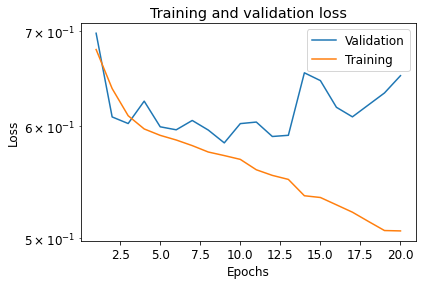

---------------------------------
40 neurons and 15 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 2s 19ms/step - loss: 0.6854 - accuracy: 0.6113 - val_loss: 0.6420 - val_accuracy: 0.6514
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6286 - accuracy: 0.6600 - val_loss: 0.6401 - val_accuracy: 0.6343
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6063 - accuracy: 0.6699 - val_loss: 0.6084 - val_accuracy: 0.6640
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5998 - accuracy: 0.6782 - val_loss: 0.6004 - val_accuracy: 0.6720
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5933 - accuracy: 0.6775 - val_loss: 0.6072 - val_accuracy: 0.6640
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5906 - accuracy: 0.6826 - val_loss: 0.6003 - val_accuracy: 0.6754
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - 

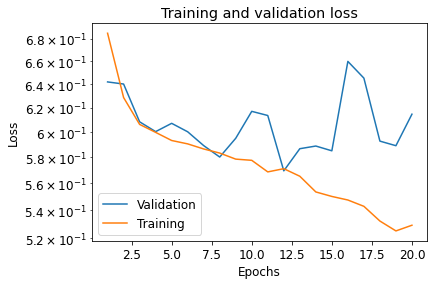

---------------------------------
40 neurons and 20 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 3s 24ms/step - loss: 0.6845 - accuracy: 0.5929 - val_loss: 0.6572 - val_accuracy: 0.6240
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6245 - accuracy: 0.6615 - val_loss: 0.6245 - val_accuracy: 0.6594
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6055 - accuracy: 0.6701 - val_loss: 0.6005 - val_accuracy: 0.6777
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 0.5965 - accuracy: 0.6843 - val_loss: 0.6069 - val_accuracy: 0.6651
Epoch 5/20
14/14 [==============================] - 0s 10ms/step - loss: 0.5925 - accuracy: 0.6882 - val_loss: 0.5780 - val_accuracy: 0.7063
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5899 - accuracy: 0.6836 - val_loss: 0.5983 - val_accuracy: 0.6823
Epoch 7/20
14/14 [==============================] - 0s 9ms/step 

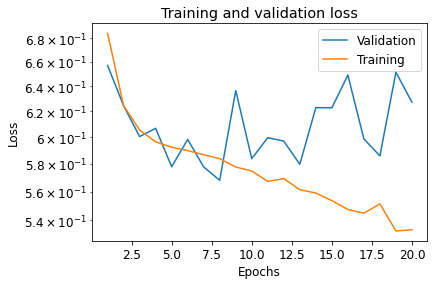

---------------------------------
40 neurons and 25 layers
---------------------------------
Epoch 1/20
14/14 [==============================] - 3s 26ms/step - loss: 0.6903 - accuracy: 0.5402 - val_loss: 0.6893 - val_accuracy: 0.4651
Epoch 2/20
14/14 [==============================] - 0s 11ms/step - loss: 0.6460 - accuracy: 0.6431 - val_loss: 0.6408 - val_accuracy: 0.6331
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.6113 - accuracy: 0.6672 - val_loss: 0.5919 - val_accuracy: 0.6806
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6079 - accuracy: 0.6699 - val_loss: 0.5841 - val_accuracy: 0.6880
Epoch 5/20
14/14 [==============================] - 0s 11ms/step - loss: 0.5973 - accuracy: 0.6794 - val_loss: 0.6253 - val_accuracy: 0.6583
Epoch 6/20
14/14 [==============================] - 0s 10ms/step - loss: 0.5945 - accuracy: 0.6875 - val_loss: 0.6036 - val_accuracy: 0.6600
Epoch 7/20
14/14 [==============================] - 0s 10ms/st

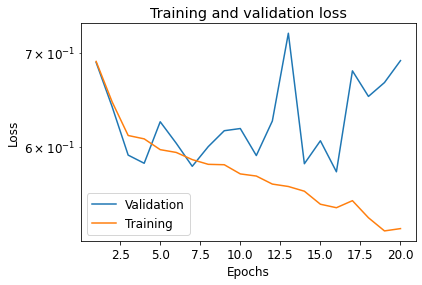

In [50]:
#Layers y units de la red neuronal
op_neurons = list(range(10, 50 , 10))
op_layers = list(range(5,30,5))

model_layers_neurons = []

for neuron in op_neurons:
    for layer in op_layers:
    
        print('---------------------------------')
        print(f'{neuron} neurons and {layer} layers')
        print('---------------------------------')

        model = create_model(neurons = neuron, layers = layer, optimizer = 'Nadam', activation = 'leaky_relu')
        plot_metric(model.history, 'loss')
        model_layers_neurons.append((neuron, layer, max(model.history.history['val_accuracy'])))

In [51]:
model_layers_neurons

[(10, 5, 0.6765714287757874),
 (10, 10, 0.6817142963409424),
 (10, 15, 0.6765714287757874),
 (10, 20, 0.6891428828239441),
 (10, 25, 0.6857143044471741),
 (20, 5, 0.6748571395874023),
 (20, 10, 0.691428542137146),
 (20, 15, 0.691428542137146),
 (20, 20, 0.691428542137146),
 (20, 25, 0.699999988079071),
 (30, 5, 0.677142858505249),
 (30, 10, 0.6919999718666077),
 (30, 15, 0.691428542137146),
 (30, 20, 0.7108571529388428),
 (30, 25, 0.677142858505249),
 (40, 5, 0.696571409702301),
 (40, 10, 0.698285698890686),
 (40, 15, 0.6988571286201477),
 (40, 20, 0.7062857151031494),
 (40, 25, 0.7045714259147644)]

## Mejor combinación:

* 20 neuronas y 20 capas internas


---------------------------------
50 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
82/82 [==============================] - 2s 10ms/step - loss: 0.6881 - accuracy: 0.5456 - val_loss: 0.7060 - val_accuracy: 0.3903
Epoch 2/20
82/82 [==============================] - 0s 6ms/step - loss: 0.6450 - accuracy: 0.6297 - val_loss: 0.6164 - val_accuracy: 0.6594
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6187 - accuracy: 0.6667 - val_loss: 0.6043 - val_accuracy: 0.6657
Epoch 4/20
82/82 [==============================] - 1s 6ms/step - loss: 0.6120 - accuracy: 0.6730 - val_loss: 0.6218 - val_accuracy: 0.6623
Epoch 5/20
82/82 [==============================] - 1s 6ms/step - loss: 0.6085 - accuracy: 0.6733 - val_loss: 0.6220 - val_accuracy: 0.6486
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6086 - accuracy: 0.6760 - val_loss: 0.6060 - val_accuracy: 0.6646
Epoch 7/20
82/82 [==============================] - 

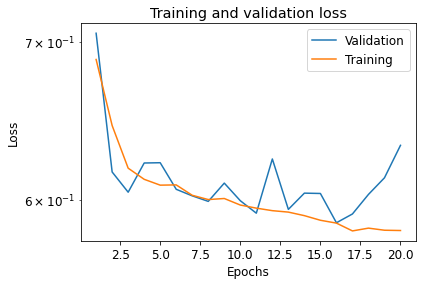

---------------------------------
50 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
82/82 [==============================] - 2s 7ms/step - loss: 0.6859 - accuracy: 0.5451 - val_loss: 0.6924 - val_accuracy: 0.4046
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6478 - val_loss: 0.6289 - val_accuracy: 0.6743
Epoch 3/20
82/82 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6610 - val_loss: 0.6151 - val_accuracy: 0.6560
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6046 - accuracy: 0.6748 - val_loss: 0.5926 - val_accuracy: 0.6720
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6012 - accuracy: 0.6738 - val_loss: 0.6121 - val_accuracy: 0.6651
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.5977 - accuracy: 0.6772 - val_loss: 0.5896 - val_accuracy: 0.6800
Epoch 7/20
82/82 [==============================] - 1s

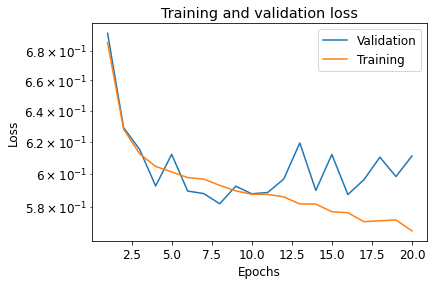

---------------------------------
50 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
82/82 [==============================] - 1s 7ms/step - loss: 0.6640 - accuracy: 0.5801 - val_loss: 0.6487 - val_accuracy: 0.6629
Epoch 2/20
82/82 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6527 - val_loss: 0.6544 - val_accuracy: 0.5846
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6127 - accuracy: 0.6750 - val_loss: 0.5892 - val_accuracy: 0.6811
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6062 - accuracy: 0.6738 - val_loss: 0.6263 - val_accuracy: 0.6229
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6049 - accuracy: 0.6664 - val_loss: 0.5945 - val_accuracy: 0.6491
Epoch 6/20
82/82 [==============================] - 0s 6ms/step - loss: 0.6026 - accuracy: 0.6792 - val_loss: 0.6049 - val_accuracy: 0.6434
Epoch 7/20
82/82 [==============================] - 0

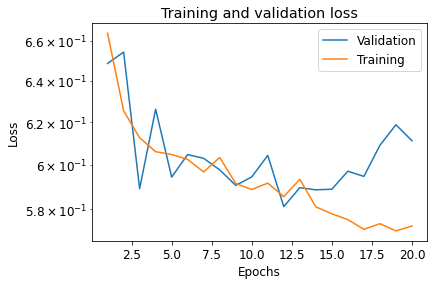

---------------------------------
50 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
82/82 [==============================] - 1s 6ms/step - loss: 0.6589 - accuracy: 0.5939 - val_loss: 0.6185 - val_accuracy: 0.6646
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6185 - accuracy: 0.6554 - val_loss: 0.6182 - val_accuracy: 0.6737
Epoch 3/20
82/82 [==============================] - 1s 7ms/step - loss: 0.6080 - accuracy: 0.6627 - val_loss: 0.6444 - val_accuracy: 0.6177
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6065 - accuracy: 0.6694 - val_loss: 0.5891 - val_accuracy: 0.6851
Epoch 5/20
82/82 [==============================] - 0s 6ms/step - loss: 0.6026 - accuracy: 0.6733 - val_loss: 0.6075 - val_accuracy: 0.6806
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.6760 - val_loss: 0.6124 - val_accuracy: 0.6634
Epoch 7/20
82/82 [==============================] - 1s

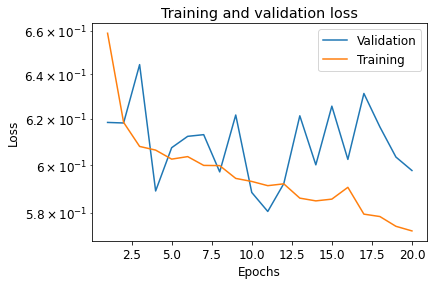

---------------------------------
50 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
82/82 [==============================] - 1s 7ms/step - loss: 0.6591 - accuracy: 0.5897 - val_loss: 0.6274 - val_accuracy: 0.6371
Epoch 2/20
82/82 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6620 - val_loss: 0.6077 - val_accuracy: 0.6246
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6200 - accuracy: 0.6598 - val_loss: 0.5963 - val_accuracy: 0.6457
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6103 - accuracy: 0.6630 - val_loss: 0.5916 - val_accuracy: 0.6686
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6046 - accuracy: 0.6725 - val_loss: 0.6034 - val_accuracy: 0.6680
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.6004 - accuracy: 0.6806 - val_loss: 0.6272 - val_accuracy: 0.6503
Epoch 7/20
82/82 [==============================] - 0

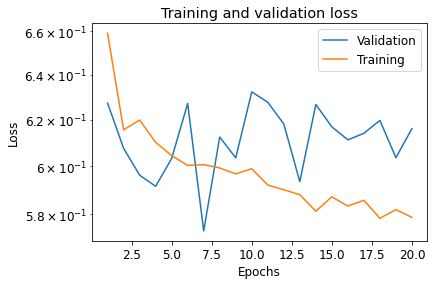

---------------------------------
100 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
41/41 [==============================] - 1s 17ms/step - loss: 0.6917 - accuracy: 0.5424 - val_loss: 0.6996 - val_accuracy: 0.3909
Epoch 2/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6733 - accuracy: 0.5995 - val_loss: 0.6401 - val_accuracy: 0.6257
Epoch 3/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6414 - accuracy: 0.6365 - val_loss: 0.6347 - val_accuracy: 0.6480
Epoch 4/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6222 - accuracy: 0.6510 - val_loss: 0.6311 - val_accuracy: 0.6657
Epoch 5/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.6605 - val_loss: 0.6018 - val_accuracy: 0.6834
Epoch 6/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6033 - accuracy: 0.6718 - val_loss: 0.5940 - val_accuracy: 0.6823
Epoch 7/20
41/41 [==============================] -

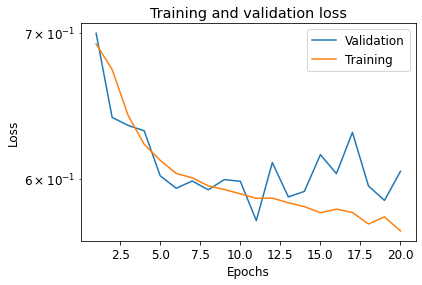

---------------------------------
100 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
41/41 [==============================] - 1s 9ms/step - loss: 0.6836 - accuracy: 0.5471 - val_loss: 0.7070 - val_accuracy: 0.3903
Epoch 2/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6434 - accuracy: 0.6252 - val_loss: 0.6529 - val_accuracy: 0.6680
Epoch 3/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6228 - accuracy: 0.6564 - val_loss: 0.6404 - val_accuracy: 0.6400
Epoch 4/20
41/41 [==============================] - 0s 7ms/step - loss: 0.6110 - accuracy: 0.6654 - val_loss: 0.6017 - val_accuracy: 0.6634
Epoch 5/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6056 - accuracy: 0.6723 - val_loss: 0.5965 - val_accuracy: 0.6514
Epoch 6/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6024 - accuracy: 0.6745 - val_loss: 0.6419 - val_accuracy: 0.6069
Epoch 7/20
41/41 [==============================] - 0

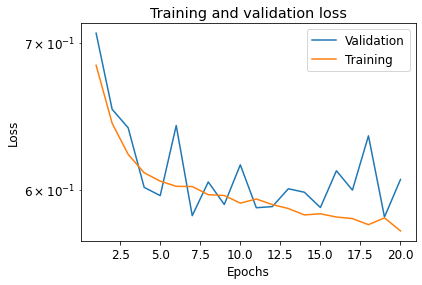

---------------------------------
100 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
41/41 [==============================] - 1s 10ms/step - loss: 0.6897 - accuracy: 0.5441 - val_loss: 0.7216 - val_accuracy: 0.3903
Epoch 2/20
41/41 [==============================] - 0s 7ms/step - loss: 0.6641 - accuracy: 0.6007 - val_loss: 0.6959 - val_accuracy: 0.5520
Epoch 3/20
41/41 [==============================] - 0s 8ms/step - loss: 0.6253 - accuracy: 0.6566 - val_loss: 0.5993 - val_accuracy: 0.6800
Epoch 4/20
41/41 [==============================] - 0s 8ms/step - loss: 0.6082 - accuracy: 0.6672 - val_loss: 0.6233 - val_accuracy: 0.6549
Epoch 5/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6101 - accuracy: 0.6699 - val_loss: 0.5853 - val_accuracy: 0.6880
Epoch 6/20
41/41 [==============================] - 0s 8ms/step - loss: 0.6001 - accuracy: 0.6733 - val_loss: 0.5805 - val_accuracy: 0.6874
Epoch 7/20
41/41 [==============================] -

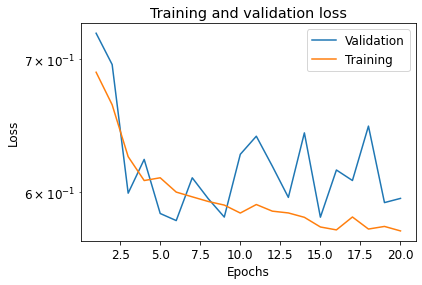

---------------------------------
100 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
41/41 [==============================] - 1s 8ms/step - loss: 0.6852 - accuracy: 0.5525 - val_loss: 0.6395 - val_accuracy: 0.6669
Epoch 2/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6242 - accuracy: 0.6529 - val_loss: 0.5930 - val_accuracy: 0.6880
Epoch 3/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6085 - accuracy: 0.6679 - val_loss: 0.6046 - val_accuracy: 0.6651
Epoch 4/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6029 - accuracy: 0.6667 - val_loss: 0.5818 - val_accuracy: 0.6920
Epoch 5/20
41/41 [==============================] - 0s 6ms/step - loss: 0.5994 - accuracy: 0.6735 - val_loss: 0.6041 - val_accuracy: 0.6754
Epoch 6/20
41/41 [==============================] - 0s 5ms/step - loss: 0.5961 - accuracy: 0.6767 - val_loss: 0.5683 - val_accuracy: 0.7109
Epoch 7/20
41/41 [==============================] - 0

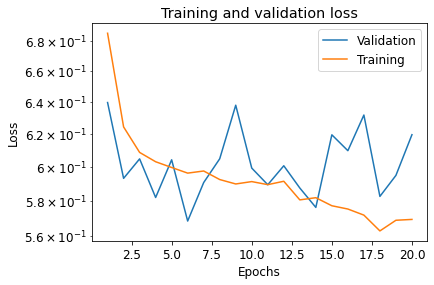

---------------------------------
100 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
41/41 [==============================] - 1s 9ms/step - loss: 0.6641 - accuracy: 0.5591 - val_loss: 0.6665 - val_accuracy: 0.6726
Epoch 2/20
41/41 [==============================] - 0s 5ms/step - loss: 0.6222 - accuracy: 0.6561 - val_loss: 0.6196 - val_accuracy: 0.6737
Epoch 3/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6068 - accuracy: 0.6642 - val_loss: 0.5839 - val_accuracy: 0.6897
Epoch 4/20
41/41 [==============================] - 0s 6ms/step - loss: 0.6052 - accuracy: 0.6706 - val_loss: 0.6145 - val_accuracy: 0.6771
Epoch 5/20
41/41 [==============================] - 0s 7ms/step - loss: 0.5978 - accuracy: 0.6794 - val_loss: 0.6226 - val_accuracy: 0.6434
Epoch 6/20
41/41 [==============================] - 0s 6ms/step - loss: 0.5970 - accuracy: 0.6767 - val_loss: 0.5870 - val_accuracy: 0.6777
Epoch 7/20
41/41 [==============================] - 

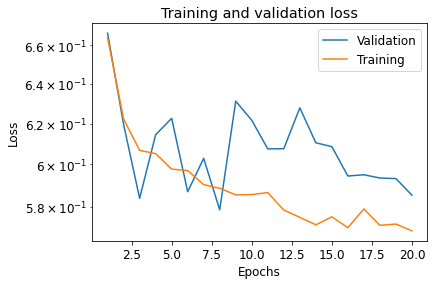

---------------------------------
150 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
28/28 [==============================] - 2s 13ms/step - loss: 0.6896 - accuracy: 0.5483 - val_loss: 0.7100 - val_accuracy: 0.3903
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6686 - accuracy: 0.5471 - val_loss: 0.6884 - val_accuracy: 0.3903
Epoch 3/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6467 - accuracy: 0.6174 - val_loss: 0.6828 - val_accuracy: 0.6240
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6357 - accuracy: 0.6623 - val_loss: 0.6651 - val_accuracy: 0.6469
Epoch 5/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 0.6662 - val_loss: 0.6461 - val_accuracy: 0.6537
Epoch 6/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6170 - accuracy: 0.6696 - val_loss: 0.6082 - val_accuracy: 0.6714
Epoch 7/20
28/28 [==============================] -

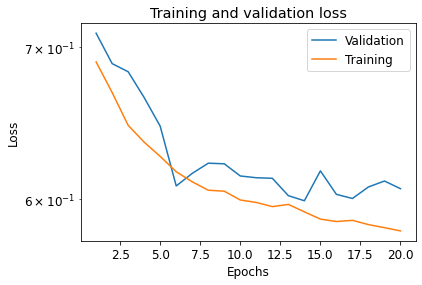

---------------------------------
150 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
28/28 [==============================] - 1s 12ms/step - loss: 0.6915 - accuracy: 0.5446 - val_loss: 0.7043 - val_accuracy: 0.3903
Epoch 2/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6727 - accuracy: 0.5789 - val_loss: 0.6311 - val_accuracy: 0.6743
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.6328 - accuracy: 0.6522 - val_loss: 0.6517 - val_accuracy: 0.6446
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6178 - accuracy: 0.6635 - val_loss: 0.5902 - val_accuracy: 0.6817
Epoch 5/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6096 - accuracy: 0.6701 - val_loss: 0.6130 - val_accuracy: 0.6560
Epoch 6/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6009 - accuracy: 0.6767 - val_loss: 0.6091 - val_accuracy: 0.6543
Epoch 7/20
28/28 [==============================] - 

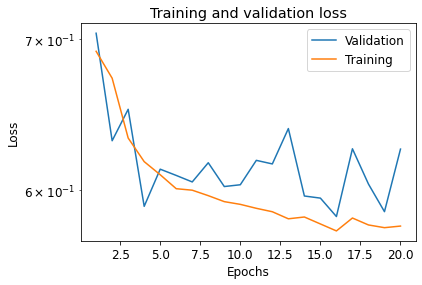

---------------------------------
150 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
28/28 [==============================] - 1s 11ms/step - loss: 0.6752 - accuracy: 0.5471 - val_loss: 0.6812 - val_accuracy: 0.6229
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6441 - accuracy: 0.6544 - val_loss: 0.6485 - val_accuracy: 0.6623
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6588 - val_loss: 0.6446 - val_accuracy: 0.6360
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6686 - val_loss: 0.5780 - val_accuracy: 0.6931
Epoch 5/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6049 - accuracy: 0.6679 - val_loss: 0.5843 - val_accuracy: 0.6840
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 0.5986 - accuracy: 0.6782 - val_loss: 0.5815 - val_accuracy: 0.6697
Epoch 7/20
28/28 [==============================] -

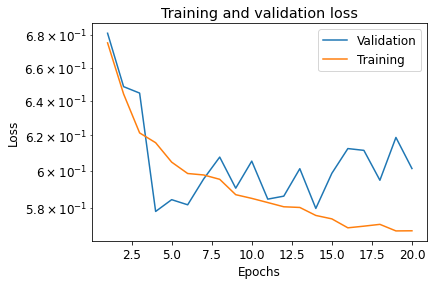

---------------------------------
150 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
28/28 [==============================] - 1s 16ms/step - loss: 0.6747 - accuracy: 0.5806 - val_loss: 0.6197 - val_accuracy: 0.6623
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 0.6271 - accuracy: 0.6574 - val_loss: 0.6250 - val_accuracy: 0.6686
Epoch 3/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6126 - accuracy: 0.6600 - val_loss: 0.6397 - val_accuracy: 0.6234
Epoch 4/20
28/28 [==============================] - 0s 7ms/step - loss: 0.6045 - accuracy: 0.6676 - val_loss: 0.6219 - val_accuracy: 0.6434
Epoch 5/20
28/28 [==============================] - 0s 6ms/step - loss: 0.6004 - accuracy: 0.6694 - val_loss: 0.5778 - val_accuracy: 0.6886
Epoch 6/20
28/28 [==============================] - 0s 8ms/step - loss: 0.5962 - accuracy: 0.6728 - val_loss: 0.6025 - val_accuracy: 0.6709
Epoch 7/20
28/28 [==============================] - 

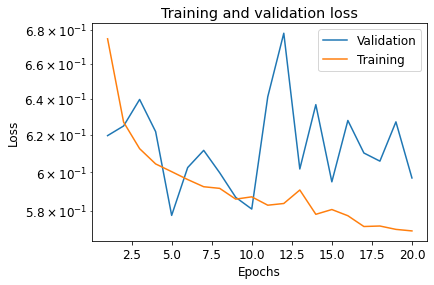

---------------------------------
150 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
28/28 [==============================] - 2s 27ms/step - loss: 0.6743 - accuracy: 0.5596 - val_loss: 0.6475 - val_accuracy: 0.6743
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6232 - accuracy: 0.6520 - val_loss: 0.6388 - val_accuracy: 0.6600
Epoch 3/20
28/28 [==============================] - 0s 9ms/step - loss: 0.6152 - accuracy: 0.6613 - val_loss: 0.5887 - val_accuracy: 0.6920
Epoch 4/20
28/28 [==============================] - 0s 8ms/step - loss: 0.6132 - accuracy: 0.6676 - val_loss: 0.6105 - val_accuracy: 0.6680
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 0.6050 - accuracy: 0.6748 - val_loss: 0.6057 - val_accuracy: 0.6726
Epoch 6/20
28/28 [==============================] - 0s 9ms/step - loss: 0.6034 - accuracy: 0.6706 - val_loss: 0.5816 - val_accuracy: 0.6960
Epoch 7/20
28/28 [==============================] -

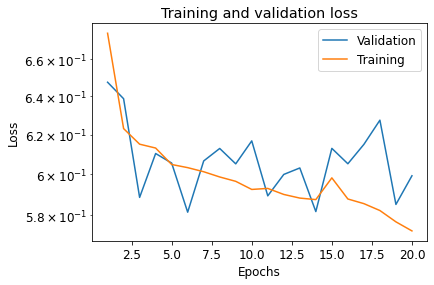

---------------------------------
200 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
21/21 [==============================] - 1s 16ms/step - loss: 0.6919 - accuracy: 0.5439 - val_loss: 0.6966 - val_accuracy: 0.3914
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5767 - val_loss: 0.6825 - val_accuracy: 0.5960
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6655 - accuracy: 0.6409 - val_loss: 0.6257 - val_accuracy: 0.6526
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6475 - accuracy: 0.6574 - val_loss: 0.6308 - val_accuracy: 0.6440
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6309 - accuracy: 0.6645 - val_loss: 0.6406 - val_accuracy: 0.6491
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6222 - accuracy: 0.6708 - val_loss: 0.6350 - val_accuracy: 0.6634
Epoch 7/20
21/21 [==============================] -

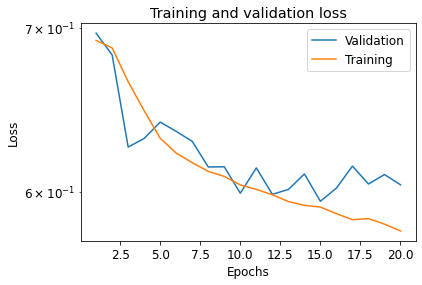

---------------------------------
200 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
21/21 [==============================] - 1s 16ms/step - loss: 0.6889 - accuracy: 0.5500 - val_loss: 0.7023 - val_accuracy: 0.3966
Epoch 2/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6583 - accuracy: 0.6221 - val_loss: 0.6333 - val_accuracy: 0.6634
Epoch 3/20
21/21 [==============================] - 0s 8ms/step - loss: 0.6271 - accuracy: 0.6512 - val_loss: 0.6518 - val_accuracy: 0.6474
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6169 - accuracy: 0.6608 - val_loss: 0.6058 - val_accuracy: 0.6697
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6095 - accuracy: 0.6645 - val_loss: 0.6318 - val_accuracy: 0.6594
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6037 - accuracy: 0.6711 - val_loss: 0.6000 - val_accuracy: 0.6771
Epoch 7/20
21/21 [==============================] - 

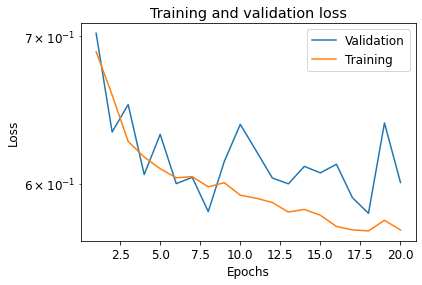

---------------------------------
200 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
21/21 [==============================] - 1s 18ms/step - loss: 0.6912 - accuracy: 0.5390 - val_loss: 0.7153 - val_accuracy: 0.3903
Epoch 2/20
21/21 [==============================] - 0s 8ms/step - loss: 0.6797 - accuracy: 0.5495 - val_loss: 0.7036 - val_accuracy: 0.5251
Epoch 3/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6390 - accuracy: 0.6275 - val_loss: 0.6482 - val_accuracy: 0.6646
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6189 - accuracy: 0.6525 - val_loss: 0.6169 - val_accuracy: 0.6720
Epoch 5/20
21/21 [==============================] - 0s 8ms/step - loss: 0.6109 - accuracy: 0.6647 - val_loss: 0.6125 - val_accuracy: 0.6789
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.6045 - accuracy: 0.6645 - val_loss: 0.6211 - val_accuracy: 0.6674
Epoch 7/20
21/21 [==============================] -

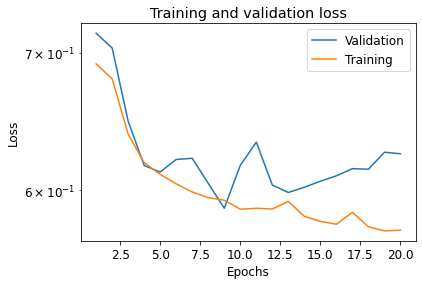

---------------------------------
200 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
21/21 [==============================] - 1s 15ms/step - loss: 0.6822 - accuracy: 0.5471 - val_loss: 0.7041 - val_accuracy: 0.3903
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6467 - accuracy: 0.6137 - val_loss: 0.6611 - val_accuracy: 0.6594
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6304 - accuracy: 0.6554 - val_loss: 0.6145 - val_accuracy: 0.6617
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6166 - accuracy: 0.6598 - val_loss: 0.6567 - val_accuracy: 0.6120
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6078 - accuracy: 0.6740 - val_loss: 0.5955 - val_accuracy: 0.6531
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6024 - accuracy: 0.6782 - val_loss: 0.5977 - val_accuracy: 0.6634
Epoch 7/20
21/21 [==============================] - 

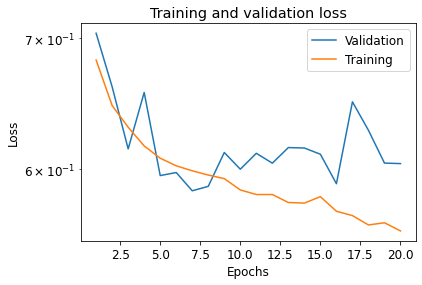

---------------------------------
200 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
21/21 [==============================] - 2s 15ms/step - loss: 0.6785 - accuracy: 0.5961 - val_loss: 0.6259 - val_accuracy: 0.6229
Epoch 2/20
21/21 [==============================] - 0s 5ms/step - loss: 0.6241 - accuracy: 0.6591 - val_loss: 0.5952 - val_accuracy: 0.6840
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6087 - accuracy: 0.6684 - val_loss: 0.6177 - val_accuracy: 0.6651
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6034 - accuracy: 0.6762 - val_loss: 0.5973 - val_accuracy: 0.6846
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 0.5996 - accuracy: 0.6755 - val_loss: 0.6018 - val_accuracy: 0.6811
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 0.5980 - accuracy: 0.6794 - val_loss: 0.6356 - val_accuracy: 0.6411
Epoch 7/20
21/21 [==============================] -

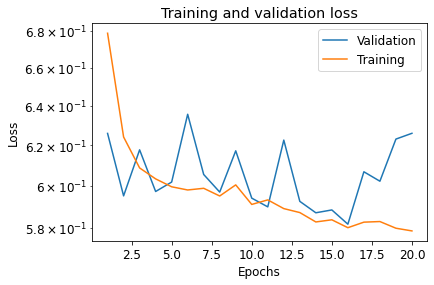

---------------------------------
250 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6916 - accuracy: 0.5449 - val_loss: 0.7023 - val_accuracy: 0.3903
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6890 - accuracy: 0.5471 - val_loss: 0.7143 - val_accuracy: 0.3903
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6823 - accuracy: 0.5471 - val_loss: 0.7117 - val_accuracy: 0.3903
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6632 - accuracy: 0.5605 - val_loss: 0.7038 - val_accuracy: 0.5320
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6481 - accuracy: 0.6387 - val_loss: 0.6785 - val_accuracy: 0.6720
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6352 - accuracy: 0.6392 - val_loss: 0.6480 - val_accuracy: 0.6834
Epoch 7/20
17/17 [==============================] -

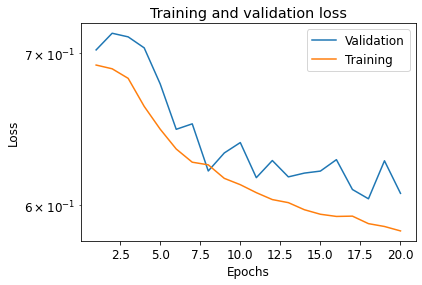

---------------------------------
250 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
17/17 [==============================] - 1s 18ms/step - loss: 0.6912 - accuracy: 0.5436 - val_loss: 0.7098 - val_accuracy: 0.3903
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.5471 - val_loss: 0.7222 - val_accuracy: 0.3903
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6670 - accuracy: 0.5471 - val_loss: 0.6856 - val_accuracy: 0.3903
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6424 - accuracy: 0.6115 - val_loss: 0.6516 - val_accuracy: 0.6686
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6267 - accuracy: 0.6561 - val_loss: 0.6078 - val_accuracy: 0.6646
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6122 - accuracy: 0.6667 - val_loss: 0.6130 - val_accuracy: 0.6497
Epoch 7/20
17/17 [==============================] - 

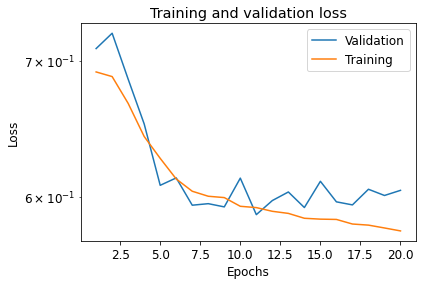

---------------------------------
250 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
17/17 [==============================] - 1s 16ms/step - loss: 0.6866 - accuracy: 0.5419 - val_loss: 0.7146 - val_accuracy: 0.3903
Epoch 2/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6520 - accuracy: 0.5498 - val_loss: 0.6863 - val_accuracy: 0.6491
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6321 - accuracy: 0.6603 - val_loss: 0.6400 - val_accuracy: 0.6851
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6172 - accuracy: 0.6574 - val_loss: 0.5951 - val_accuracy: 0.6703
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6060 - accuracy: 0.6610 - val_loss: 0.5852 - val_accuracy: 0.6783
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5994 - accuracy: 0.6757 - val_loss: 0.5890 - val_accuracy: 0.6937
Epoch 7/20
17/17 [==============================] -

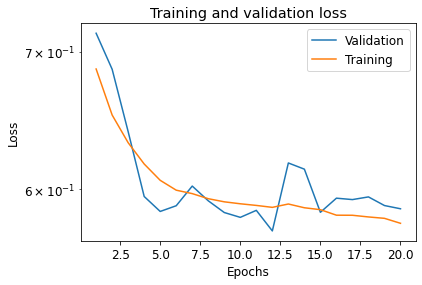

---------------------------------
250 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
17/17 [==============================] - 1s 16ms/step - loss: 0.6874 - accuracy: 0.5404 - val_loss: 0.7276 - val_accuracy: 0.3903
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6557 - accuracy: 0.5566 - val_loss: 0.6668 - val_accuracy: 0.6720
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6338 - accuracy: 0.6525 - val_loss: 0.6546 - val_accuracy: 0.6457
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6176 - accuracy: 0.6554 - val_loss: 0.6079 - val_accuracy: 0.6406
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6069 - accuracy: 0.6694 - val_loss: 0.5816 - val_accuracy: 0.6789
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5991 - accuracy: 0.6711 - val_loss: 0.5959 - val_accuracy: 0.6537
Epoch 7/20
17/17 [==============================] - 

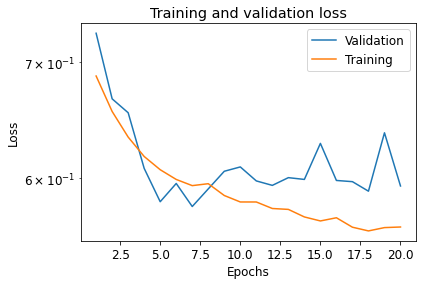

---------------------------------
250 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.6861 - accuracy: 0.5338 - val_loss: 0.7094 - val_accuracy: 0.3909
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6427 - accuracy: 0.6292 - val_loss: 0.6401 - val_accuracy: 0.6560
Epoch 3/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6207 - accuracy: 0.6569 - val_loss: 0.6309 - val_accuracy: 0.6606
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6105 - accuracy: 0.6627 - val_loss: 0.6210 - val_accuracy: 0.6657
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6041 - accuracy: 0.6708 - val_loss: 0.6046 - val_accuracy: 0.6714
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6023 - accuracy: 0.6770 - val_loss: 0.6114 - val_accuracy: 0.6720
Epoch 7/20
17/17 [==============================] -

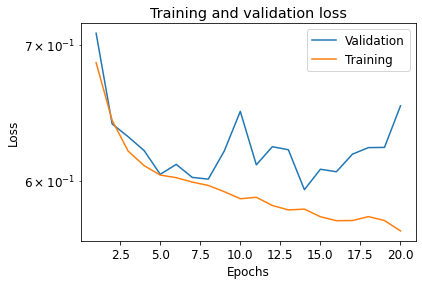

---------------------------------
300 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 20ms/step - loss: 0.6925 - accuracy: 0.5407 - val_loss: 0.6974 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5471 - val_loss: 0.7029 - val_accuracy: 0.3903
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6884 - accuracy: 0.5471 - val_loss: 0.7094 - val_accuracy: 0.3903
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6786 - accuracy: 0.5471 - val_loss: 0.7142 - val_accuracy: 0.3903
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6596 - accuracy: 0.5471 - val_loss: 0.6940 - val_accuracy: 0.3903
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6495 - accuracy: 0.5949 - val_loss: 0.6708 - val_accuracy: 0.6617
Epoch 7/20
14/14 [==============================] -

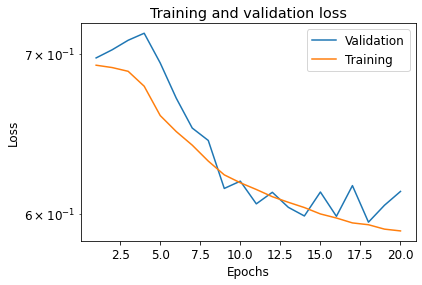

---------------------------------
300 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 25ms/step - loss: 0.6909 - accuracy: 0.5468 - val_loss: 0.7100 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6754 - accuracy: 0.5471 - val_loss: 0.7065 - val_accuracy: 0.3903
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6485 - accuracy: 0.5672 - val_loss: 0.6683 - val_accuracy: 0.6783
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6383 - accuracy: 0.6532 - val_loss: 0.6580 - val_accuracy: 0.6657
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6275 - accuracy: 0.6591 - val_loss: 0.6339 - val_accuracy: 0.6709
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6173 - accuracy: 0.6662 - val_loss: 0.5997 - val_accuracy: 0.6760
Epoch 7/20
14/14 [==============================] - 

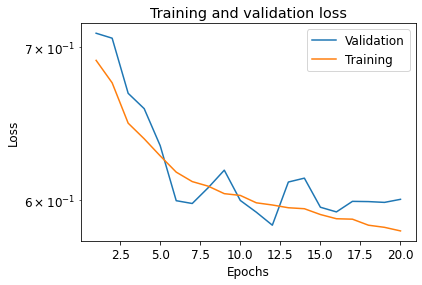

---------------------------------
300 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 21ms/step - loss: 0.6915 - accuracy: 0.5407 - val_loss: 0.7077 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6828 - accuracy: 0.5471 - val_loss: 0.7128 - val_accuracy: 0.3903
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6536 - accuracy: 0.5488 - val_loss: 0.6668 - val_accuracy: 0.6857
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6298 - accuracy: 0.6591 - val_loss: 0.6097 - val_accuracy: 0.6840
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6135 - accuracy: 0.6574 - val_loss: 0.5912 - val_accuracy: 0.6674
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6069 - accuracy: 0.6659 - val_loss: 0.5957 - val_accuracy: 0.6589
Epoch 7/20
14/14 [==============================] -

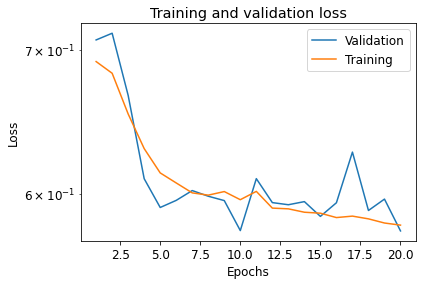

---------------------------------
300 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 47ms/step - loss: 0.6853 - accuracy: 0.5468 - val_loss: 0.7168 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6487 - accuracy: 0.5640 - val_loss: 0.6622 - val_accuracy: 0.6977
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6314 - accuracy: 0.6451 - val_loss: 0.6342 - val_accuracy: 0.6920
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6207 - accuracy: 0.6537 - val_loss: 0.6216 - val_accuracy: 0.6451
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6096 - accuracy: 0.6620 - val_loss: 0.5963 - val_accuracy: 0.6794
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6049 - accuracy: 0.6696 - val_loss: 0.5799 - val_accuracy: 0.6926
Epoch 7/20
14/14 [==============================] - 

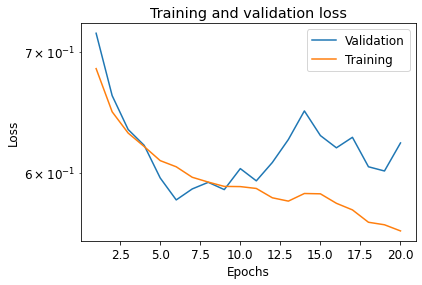

---------------------------------
300 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
14/14 [==============================] - 1s 21ms/step - loss: 0.6899 - accuracy: 0.5363 - val_loss: 0.7182 - val_accuracy: 0.3903
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6626 - accuracy: 0.5542 - val_loss: 0.6748 - val_accuracy: 0.6634
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6299 - accuracy: 0.6439 - val_loss: 0.6072 - val_accuracy: 0.6594
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6142 - accuracy: 0.6632 - val_loss: 0.6161 - val_accuracy: 0.6669
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6054 - accuracy: 0.6686 - val_loss: 0.6028 - val_accuracy: 0.6714
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5974 - accuracy: 0.6728 - val_loss: 0.6242 - val_accuracy: 0.6354
Epoch 7/20
14/14 [==============================] -

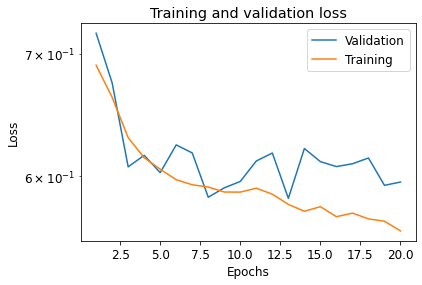

---------------------------------
350 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 0.6927 - accuracy: 0.5402 - val_loss: 0.6959 - val_accuracy: 0.3903
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.5471 - val_loss: 0.6973 - val_accuracy: 0.3909
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6890 - accuracy: 0.5603 - val_loss: 0.6921 - val_accuracy: 0.5074
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6791 - accuracy: 0.6216 - val_loss: 0.6594 - val_accuracy: 0.6137
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6613 - accuracy: 0.6375 - val_loss: 0.6490 - val_accuracy: 0.5891
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6483 - accuracy: 0.6461 - val_loss: 0.6223 - val_accuracy: 0.6349
Epoch 7/20
12/12 [==============================] 

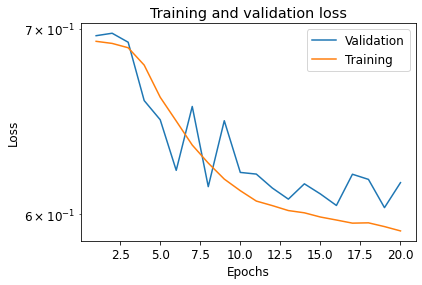

---------------------------------
350 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
12/12 [==============================] - 1s 23ms/step - loss: 0.6925 - accuracy: 0.5382 - val_loss: 0.6966 - val_accuracy: 0.3903
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6911 - accuracy: 0.5471 - val_loss: 0.7019 - val_accuracy: 0.3903
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6879 - accuracy: 0.5471 - val_loss: 0.7065 - val_accuracy: 0.3903
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6743 - accuracy: 0.5613 - val_loss: 0.6841 - val_accuracy: 0.5846
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6398 - accuracy: 0.6446 - val_loss: 0.6623 - val_accuracy: 0.6463
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6209 - accuracy: 0.6547 - val_loss: 0.6225 - val_accuracy: 0.6651
Epoch 7/20
12/12 [==============================] -

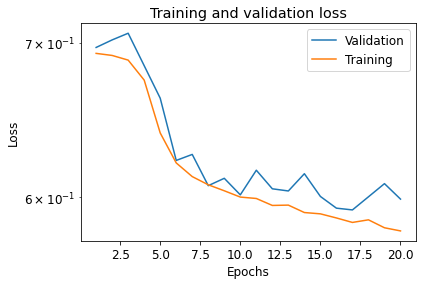

---------------------------------
350 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 0.6905 - accuracy: 0.5463 - val_loss: 0.7181 - val_accuracy: 0.3903
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6696 - accuracy: 0.5471 - val_loss: 0.6953 - val_accuracy: 0.3903
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6480 - accuracy: 0.5949 - val_loss: 0.6778 - val_accuracy: 0.6606
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6335 - accuracy: 0.6603 - val_loss: 0.6528 - val_accuracy: 0.6611
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6218 - accuracy: 0.6645 - val_loss: 0.6174 - val_accuracy: 0.6669
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6120 - accuracy: 0.6718 - val_loss: 0.6061 - val_accuracy: 0.6703
Epoch 7/20
12/12 [==============================] -

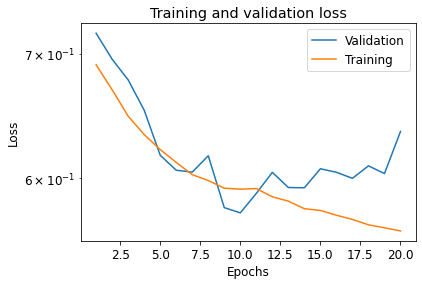

---------------------------------
350 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
12/12 [==============================] - 2s 25ms/step - loss: 0.6882 - accuracy: 0.5792 - val_loss: 0.6674 - val_accuracy: 0.6246
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6550 - accuracy: 0.6395 - val_loss: 0.6345 - val_accuracy: 0.6291
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6273 - accuracy: 0.6664 - val_loss: 0.6028 - val_accuracy: 0.6714
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6123 - accuracy: 0.6667 - val_loss: 0.6012 - val_accuracy: 0.6766
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6034 - accuracy: 0.6701 - val_loss: 0.6014 - val_accuracy: 0.6703
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6000 - accuracy: 0.6745 - val_loss: 0.6411 - val_accuracy: 0.6211
Epoch 7/20
12/12 [==============================] - 

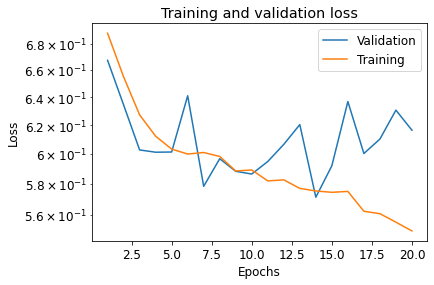

---------------------------------
350 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
12/12 [==============================] - 1s 25ms/step - loss: 0.6779 - accuracy: 0.5478 - val_loss: 0.7189 - val_accuracy: 0.3920
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6398 - accuracy: 0.6218 - val_loss: 0.6497 - val_accuracy: 0.6674
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6194 - accuracy: 0.6618 - val_loss: 0.6713 - val_accuracy: 0.6029
Epoch 4/20
12/12 [==============================] - 0s 6ms/step - loss: 0.6128 - accuracy: 0.6681 - val_loss: 0.6208 - val_accuracy: 0.6737
Epoch 5/20
12/12 [==============================] - 0s 8ms/step - loss: 0.6053 - accuracy: 0.6738 - val_loss: 0.5966 - val_accuracy: 0.6640
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 0.5986 - accuracy: 0.6787 - val_loss: 0.6013 - val_accuracy: 0.6714
Epoch 7/20
12/12 [==============================] -

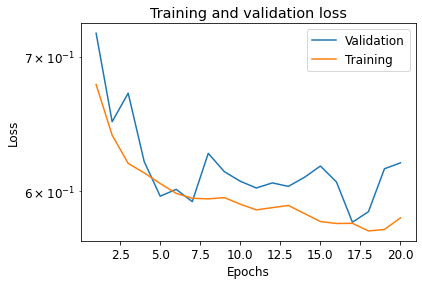

---------------------------------
400 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
11/11 [==============================] - 1s 26ms/step - loss: 0.6927 - accuracy: 0.5436 - val_loss: 0.6959 - val_accuracy: 0.3903
Epoch 2/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5471 - val_loss: 0.6991 - val_accuracy: 0.3903
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5471 - val_loss: 0.7029 - val_accuracy: 0.3903
Epoch 4/20
11/11 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5471 - val_loss: 0.7067 - val_accuracy: 0.3903
Epoch 5/20
11/11 [==============================] - 0s 10ms/step - loss: 0.6886 - accuracy: 0.5471 - val_loss: 0.7081 - val_accuracy: 0.3903
Epoch 6/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6847 - accuracy: 0.5510 - val_loss: 0.6969 - val_accuracy: 0.4509
Epoch 7/20
11/11 [==============================] 

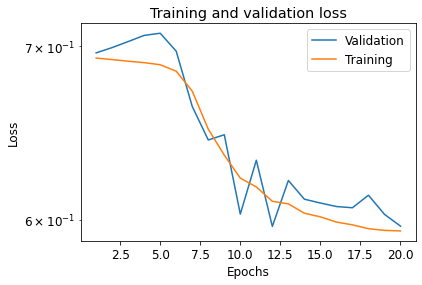

---------------------------------
400 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
11/11 [==============================] - 1s 25ms/step - loss: 0.6921 - accuracy: 0.5373 - val_loss: 0.6994 - val_accuracy: 0.3903
Epoch 2/20
11/11 [==============================] - 0s 8ms/step - loss: 0.6892 - accuracy: 0.5471 - val_loss: 0.7072 - val_accuracy: 0.3903
Epoch 3/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6804 - accuracy: 0.5471 - val_loss: 0.7118 - val_accuracy: 0.3903
Epoch 4/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6556 - accuracy: 0.5721 - val_loss: 0.6568 - val_accuracy: 0.6863
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6308 - accuracy: 0.6275 - val_loss: 0.6172 - val_accuracy: 0.6966
Epoch 6/20
11/11 [==============================] - 0s 9ms/step - loss: 0.6164 - accuracy: 0.6532 - val_loss: 0.6270 - val_accuracy: 0.6891
Epoch 7/20
11/11 [==============================] - 

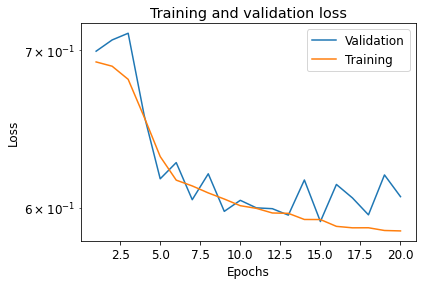

---------------------------------
400 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
11/11 [==============================] - 1s 24ms/step - loss: 0.6918 - accuracy: 0.5657 - val_loss: 0.6890 - val_accuracy: 0.5760
Epoch 2/20
11/11 [==============================] - 0s 8ms/step - loss: 0.6774 - accuracy: 0.6333 - val_loss: 0.6398 - val_accuracy: 0.6263
Epoch 3/20
11/11 [==============================] - 0s 9ms/step - loss: 0.6529 - accuracy: 0.6517 - val_loss: 0.6140 - val_accuracy: 0.6457
Epoch 4/20
11/11 [==============================] - 0s 8ms/step - loss: 0.6355 - accuracy: 0.6613 - val_loss: 0.6611 - val_accuracy: 0.6103
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6209 - accuracy: 0.6659 - val_loss: 0.6205 - val_accuracy: 0.6514
Epoch 6/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6109 - accuracy: 0.6718 - val_loss: 0.6193 - val_accuracy: 0.6543
Epoch 7/20
11/11 [==============================] -

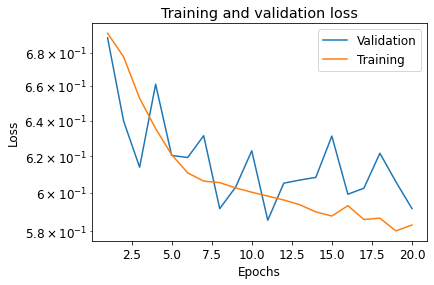

---------------------------------
400 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
11/11 [==============================] - 1s 28ms/step - loss: 0.6915 - accuracy: 0.5441 - val_loss: 0.7089 - val_accuracy: 0.3903
Epoch 2/20
11/11 [==============================] - 0s 9ms/step - loss: 0.6885 - accuracy: 0.5471 - val_loss: 0.7252 - val_accuracy: 0.3903
Epoch 3/20
11/11 [==============================] - 0s 9ms/step - loss: 0.6752 - accuracy: 0.5471 - val_loss: 0.7027 - val_accuracy: 0.3903
Epoch 4/20
11/11 [==============================] - 0s 10ms/step - loss: 0.6405 - accuracy: 0.5953 - val_loss: 0.6333 - val_accuracy: 0.7000
Epoch 5/20
11/11 [==============================] - 0s 10ms/step - loss: 0.6238 - accuracy: 0.6561 - val_loss: 0.6204 - val_accuracy: 0.6566
Epoch 6/20
11/11 [==============================] - 0s 11ms/step - loss: 0.6120 - accuracy: 0.6610 - val_loss: 0.5802 - val_accuracy: 0.6680
Epoch 7/20
11/11 [==============================]

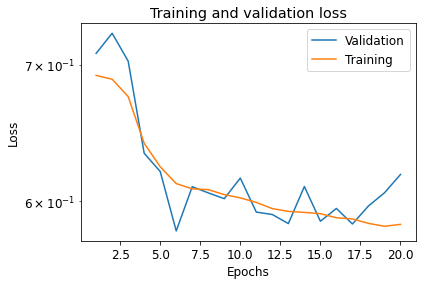

---------------------------------
400 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
11/11 [==============================] - 1s 26ms/step - loss: 0.6890 - accuracy: 0.5431 - val_loss: 0.7231 - val_accuracy: 0.3903
Epoch 2/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6648 - accuracy: 0.5532 - val_loss: 0.6911 - val_accuracy: 0.6514
Epoch 3/20
11/11 [==============================] - 0s 9ms/step - loss: 0.6340 - accuracy: 0.6598 - val_loss: 0.6066 - val_accuracy: 0.6777
Epoch 4/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6212 - accuracy: 0.6600 - val_loss: 0.6356 - val_accuracy: 0.6669
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.6138 - accuracy: 0.6716 - val_loss: 0.5894 - val_accuracy: 0.6777
Epoch 6/20
11/11 [==============================] - 0s 11ms/step - loss: 0.6131 - accuracy: 0.6708 - val_loss: 0.6162 - val_accuracy: 0.6594
Epoch 7/20
11/11 [==============================] 

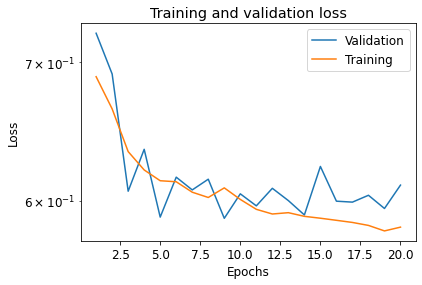

---------------------------------
450 batch size and 0.0005 learning rate
---------------------------------
Epoch 1/20
10/10 [==============================] - 1s 29ms/step - loss: 0.6925 - accuracy: 0.5284 - val_loss: 0.6957 - val_accuracy: 0.3903
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6892 - accuracy: 0.5471 - val_loss: 0.6985 - val_accuracy: 0.3903
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6806 - accuracy: 0.5471 - val_loss: 0.7023 - val_accuracy: 0.3903
Epoch 4/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6627 - accuracy: 0.5471 - val_loss: 0.7129 - val_accuracy: 0.3903
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.6538 - accuracy: 0.5471 - val_loss: 0.6855 - val_accuracy: 0.3903
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6452 - accuracy: 0.5483 - val_loss: 0.6816 - val_accuracy: 0.6166
Epoch 7/20
10/10 [==============================] 

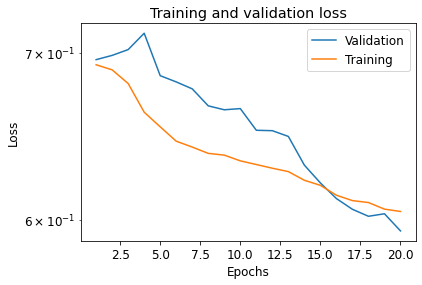

---------------------------------
450 batch size and 0.001 learning rate
---------------------------------
Epoch 1/20
10/10 [==============================] - 1s 32ms/step - loss: 0.6923 - accuracy: 0.5331 - val_loss: 0.6952 - val_accuracy: 0.4029
Epoch 2/20
10/10 [==============================] - 0s 10ms/step - loss: 0.6873 - accuracy: 0.5902 - val_loss: 0.6889 - val_accuracy: 0.5743
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6709 - accuracy: 0.6434 - val_loss: 0.6440 - val_accuracy: 0.6314
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.6437 - accuracy: 0.6493 - val_loss: 0.6684 - val_accuracy: 0.5966
Epoch 5/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6343 - accuracy: 0.6542 - val_loss: 0.6451 - val_accuracy: 0.6274
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: 0.6246 - accuracy: 0.6645 - val_loss: 0.6379 - val_accuracy: 0.6349
Epoch 7/20
10/10 [==============================] -

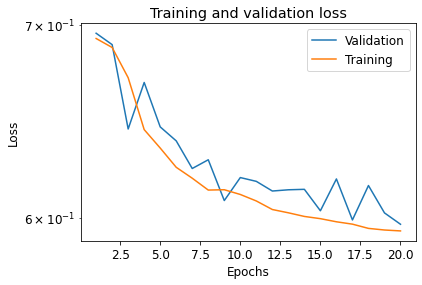

---------------------------------
450 batch size and 0.0015 learning rate
---------------------------------
Epoch 1/20
10/10 [==============================] - 2s 33ms/step - loss: 0.6904 - accuracy: 0.5471 - val_loss: 0.7149 - val_accuracy: 0.3903
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6812 - accuracy: 0.5471 - val_loss: 0.7111 - val_accuracy: 0.3903
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6496 - accuracy: 0.5978 - val_loss: 0.6637 - val_accuracy: 0.6789
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.6247 - accuracy: 0.6593 - val_loss: 0.6057 - val_accuracy: 0.6714
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.6137 - accuracy: 0.6669 - val_loss: 0.6103 - val_accuracy: 0.6794
Epoch 6/20
10/10 [==============================] - 0s 10ms/step - loss: 0.6100 - accuracy: 0.6716 - val_loss: 0.5912 - val_accuracy: 0.6800
Epoch 7/20
10/10 [==============================]

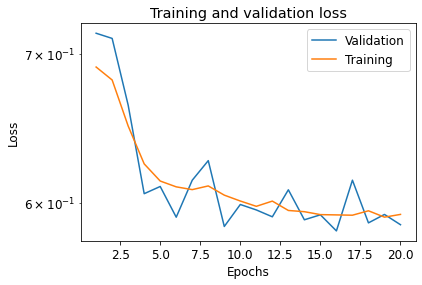

---------------------------------
450 batch size and 0.002 learning rate
---------------------------------
Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 0.6913 - accuracy: 0.5441 - val_loss: 0.7101 - val_accuracy: 0.3903
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6813 - accuracy: 0.5471 - val_loss: 0.7132 - val_accuracy: 0.3903
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6429 - accuracy: 0.6017 - val_loss: 0.6063 - val_accuracy: 0.6863
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6187 - accuracy: 0.6498 - val_loss: 0.6124 - val_accuracy: 0.6686
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.6099 - accuracy: 0.6642 - val_loss: 0.6167 - val_accuracy: 0.6509
Epoch 6/20
10/10 [==============================] - 0s 11ms/step - loss: 0.6055 - accuracy: 0.6708 - val_loss: 0.6005 - val_accuracy: 0.6623
Epoch 7/20
10/10 [==============================] 

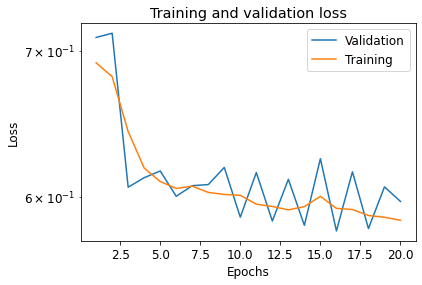

---------------------------------
450 batch size and 0.0025 learning rate
---------------------------------
Epoch 1/20
10/10 [==============================] - 1s 26ms/step - loss: 0.6906 - accuracy: 0.5360 - val_loss: 0.7148 - val_accuracy: 0.3903
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6772 - accuracy: 0.5478 - val_loss: 0.6982 - val_accuracy: 0.5069
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6423 - accuracy: 0.6221 - val_loss: 0.6253 - val_accuracy: 0.6897
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6295 - accuracy: 0.6355 - val_loss: 0.6506 - val_accuracy: 0.6623
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.6235 - accuracy: 0.6321 - val_loss: 0.6228 - val_accuracy: 0.6743
Epoch 6/20
10/10 [==============================] - 0s 11ms/step - loss: 0.6146 - accuracy: 0.6444 - val_loss: 0.6454 - val_accuracy: 0.6331
Epoch 7/20
10/10 [==============================] 

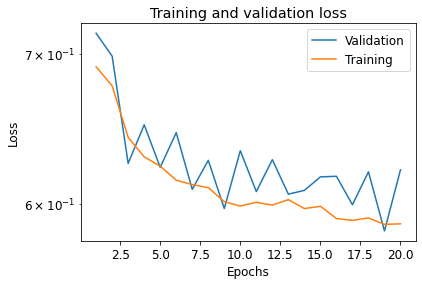

In [63]:
#ajuste hiperparametros batchsize y learning rate

op_batchsize = list(range(50,500,50))
op_learning_rate = list(np.arange(0.0005, 0.003, 0.0005))


model_lr_batch = []
for batch in op_batchsize:
    for lr in op_learning_rate:
    
        print('---------------------------------')
        print(f'{batch} batch size and {lr} learning rate')
        print('---------------------------------')

        model = create_model(neurons = 20, 
                             layers = 20, 
                             optimizer = optimizers.Adam(learning_rate=lr), 
                             activation = 'leaky_relu', 
                             batch_size=batch)
        
        plot_metric(model.history, 'loss')
        model_lr_batch.append((batch, lr, max(model.history.history['val_accuracy'])))

In [64]:
model_lr_batch

[(50, 0.0005, 0.6977142691612244),
 (50, 0.001, 0.6919999718666077),
 (50, 0.0015, 0.6811428666114807),
 (50, 0.002, 0.7005714178085327),
 (50, 0.0025, 0.6885714530944824),
 (100, 0.0005, 0.6908571720123291),
 (100, 0.001, 0.6834285855293274),
 (100, 0.0015, 0.693142831325531),
 (100, 0.002, 0.7154285907745361),
 (100, 0.0025, 0.6902857422828674),
 (150, 0.0005, 0.6714285612106323),
 (150, 0.001, 0.6919999718666077),
 (150, 0.0015, 0.693142831325531),
 (150, 0.002, 0.7011428475379944),
 (150, 0.0025, 0.7057142853736877),
 (200, 0.0005, 0.696571409702301),
 (200, 0.001, 0.7022857069969177),
 (200, 0.0015, 0.6977142691612244),
 (200, 0.002, 0.6857143044471741),
 (200, 0.0025, 0.6971428394317627),
 (250, 0.0005, 0.6988571286201477),
 (250, 0.001, 0.668571412563324),
 (250, 0.0015, 0.6937142610549927),
 (250, 0.002, 0.678857147693634),
 (250, 0.0025, 0.671999990940094),
 (300, 0.0005, 0.6708571314811707),
 (300, 0.001, 0.6817142963409424),
 (300, 0.0015, 0.6857143044471741),
 (300, 0.002, 

## Muy similares todos:

* Utilizaremos 350 de batch size y 0.001 de learning rate


Epoch 1/20
14/14 [==============================] - 1s 12ms/step - loss: 0.7117 - accuracy: 0.4652 - val_loss: 0.6796 - val_accuracy: 0.5960
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6839 - accuracy: 0.5586 - val_loss: 0.6692 - val_accuracy: 0.5874
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6678 - accuracy: 0.6245 - val_loss: 0.6504 - val_accuracy: 0.6097
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6507 - accuracy: 0.6353 - val_loss: 0.6373 - val_accuracy: 0.6149
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6341 - accuracy: 0.6485 - val_loss: 0.6322 - val_accuracy: 0.6046
Epoch 6/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6218 - accuracy: 0.6561 - val_loss: 0.6297 - val_accuracy: 0.6137
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6145 - accuracy: 0.6603 - val_loss: 0.6242 - val_accuracy: 0.6183
Epoch 8/20
14/14 [=

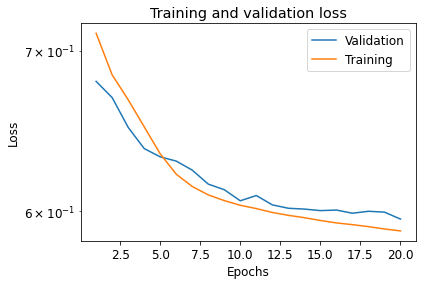

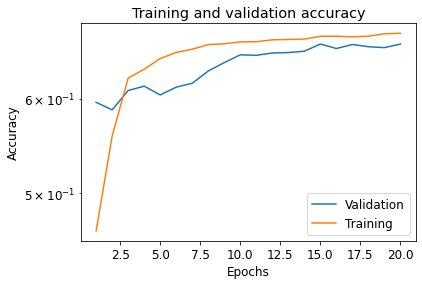

In [54]:
#Modelo final

model = create_model(neurons = 20, 
             layers = 5, 
             optimizer = 'Adam', 
             activation = 'leaky_relu',
             epochs=20)

plot_metric(model.history, 'loss')
plot_metric(model.history, 'accuracy')

* Se guarda el modelo pero usaremos el modelo de randomforest optimizado previamente ya que la red neuronal no supone una mejora significativa

In [55]:
joblib.dump(model, 'modelo_entrenado_ajustado.pkl')

INFO:tensorflow:Assets written to: ram://6faae39f352e4fc3b4cc8a6830934ca2/assets


['modelo_entrenado_ajustado.pkl']

## Prediccion en el conjunto de test

In [56]:
results_proba = model.predict(X_test)
results_pred = [1 if proba[0] < 0.5 else 0 for proba in results_proba ]

42/42 [==============================] - 0s 1ms/step


In [57]:
accuracy = sum(results_pred == y_test) / len(y_test)
print("Precisión: {:.2f}".format(accuracy))

Precisión: 0.67


### No se consigue mejorar la precision 
### Random Forest sera el seleccionado para el front end por tener una precision y recall similares

### Mejoras futuras
* Adquisicion de mas datos de otras compañias
* Obtencion de nuevas variables (Feature engineering)